# Analysis of Press Releases

In [4]:
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import random
import re 
from langdetect import detect_langs

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%xmode Minimal

Exception reporting mode: Minimal


In [5]:
df_list = []

states = ['arizona', 'california', 'colorado', 'connecticut','idaho', 'illinois', 
         'minnesota', 'nevada', 'ohio', 'oregon', 'utah', 'wisconsin', 'west_virginia']

for state in states: 
    df = pd.read_csv(f'{state}_2023.csv')
    df_list.append(df)

In [6]:
pr = pd.concat(df_list)

In [7]:
pr.info()
pr.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3664 entries, 0 to 242
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3664 non-null   object 
 1   link          3664 non-null   object 
 2   content       3664 non-null   object 
 3   date_clean    3664 non-null   object 
 4   page_scraped  1448 non-null   float64
dtypes: float64(1), object(4)
memory usage: 171.8+ KB


,title,link,content,date_clean,page_scraped
0,Governor’s Office Demands ESA Transparency and...,https://azgovernor.gov/office-arizona-governor...,ESA program has surpassed expected budget esti...,2023-12-21,NaN
1,Governor Katie Hobbs Signs Executive Order Sen...,https://azgovernor.gov/office-arizona-governor...,Guard to Assist DPS and Local Law Enforcement ...,2023-12-15,NaN
2,Governor Katie Hobbs Announces Federal Grant t...,https://azgovernor.gov/office-arizona-governor...,"Phoenix, AZ – Today, Governor Katie Hobbs anno...",2023-12-08,NaN
3,Governor Katie Hobbs Launches Operation SECURE...,https://azgovernor.gov/office-arizona-governor...,State Charges Federal Government for Costs of ...,2023-12-08,NaN
4,"Sinema, Kelly, Hobbs Statement on Lukeville PO...",https://azgovernor.gov/office-arizona-governor...,ARIZONA – Arizona Senators Kyrsten Sinema and ...,2023-12-01,NaN


In [8]:
# load individual dfs 
arizona = pd.read_csv('arizona_2023.csv')
california = pd.read_csv('california_2023.csv')
colorado = pd.read_csv('colorado_2023.csv')
connecticut = pd.read_csv('connecticut_2023.csv')
idaho = pd.read_csv('idaho_2023.csv')
illinois = pd.read_csv('illinois_2023.csv')
minnesota = pd.read_csv('minnesota_2023.csv')
nevada = pd.read_csv('nevada_2023.csv')
ohio = pd.read_csv('ohio_2023.csv')
oregon = pd.read_csv('oregon_2023.csv')
utah = pd.read_csv('utah_2023.csv')
wisconsin = pd.read_csv('wisconsin_2023.csv')
west_virginia = pd.read_csv('west_virginia_2023.csv')

In [9]:
# examine dfs
arizona.info()
california.info()
colorado.info()
connecticut.info()
idaho.info()
illinois.info()
minnesota.info()
nevada.info()
ohio.info()
oregon.info()
utah.info()
wisconsin.info()
west_virginia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       150 non-null    object
 1   link        150 non-null    object
 2   content     150 non-null    object
 3   date_clean  150 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         608 non-null    object
 1   link          608 non-null    object
 2   content       608 non-null    object
 3   page_scraped  608 non-null    int64 
 4   date_clean    608 non-null    object
dtypes: int64(1), object(4)
memory usage: 23.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --

## Explore outliers 

In [10]:
df_list = [arizona, california, colorado, connecticut, idaho, illinois, minnesota, nevada, ohio, oregon, 
          utah, wisconsin, west_virginia]

In [11]:
def add_word_count(df):
    df['word_count'] = [len(i.split()) for i in df.content]

In [12]:
for i in df_list:
    add_word_count(i)

In [13]:
# check this worked 
west_virginia.head()

,title,link,content,date_clean,word_count
0,Gov. Justice issues proclamation declaring ext...,https://governor.wv.gov/News/press-releases/20...,"CHARLESTON, WV — Gov. Jim Justice has issued a...",2023-12-21,45
1,Gov. Justice awards $1 million grant to West V...,https://governor.wv.gov/News/press-releases/20...,"CHARLESTON, WV —Gov. Jim Justice today present...",2023-12-21,303
2,Gov. Justice announces Water Development Autho...,https://governor.wv.gov/News/press-releases/20...,"CHARLESTON, WV — Gov. Justice announced today ...",2023-12-21,512
3,Gov. Justice orders flags to be flown at half-...,https://governor.wv.gov/News/press-releases/20...,"CHARLESTON, WV – Gov. Jim Justice has issued a...",2023-12-21,131
4,Gov. Justice issues proclamation declaring ext...,https://governor.wv.gov/News/press-releases/20...,"CHARLESTON, WV — Gov. Jim Justice has issued a...",2023-12-20,87


In [14]:
## Examine distribution of word count

In [15]:
def plot_distribution(df, state): 
    # get values
    max_wc = round(df.word_count.max())
    x_position = round(0.70 * max_wc)
    mean_wc = round(df.word_count.mean())
    med_wc = round(df.word_count.median())
    count = df.shape[0]
    
    # plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.hist(df.word_count, bins = 50, color = 'lightblue')
    top_lim = ax.get_ylim()[1]
    y_position1 = round(0.9 * top_lim) 
    y_position2 = y_position1 - 5 
    ax.text(x_position, y_position1, f'Mean length: {str(mean_wc)} words')
    plt.axvline(x = mean_wc, color = 'dimgrey',ls = 'dashed')
    ax.text(x_position, y_position2, f'Median length: {str(med_wc)} words')
    plt.title(f'From {str(count)} Press Releases in 2023', size = 10)
    plt.suptitle(f'Distribution of Document Length - {state}', size = 20)
    plt.xlabel('Document Word Count')
    plt.ylabel('Number of Documents')

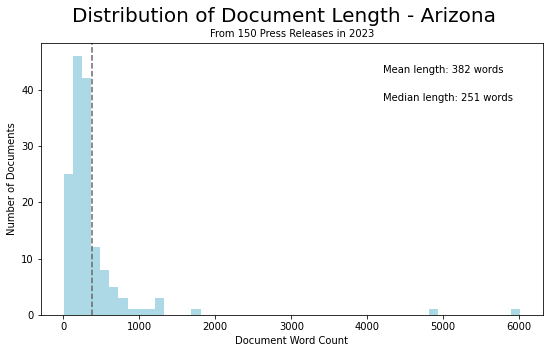

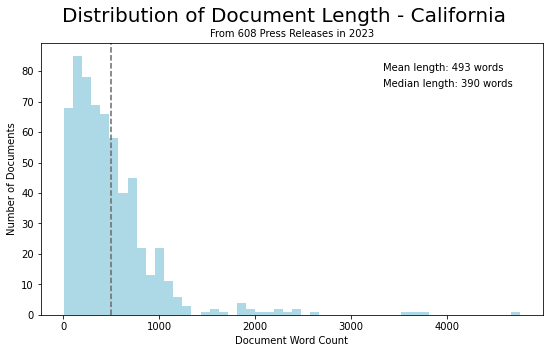

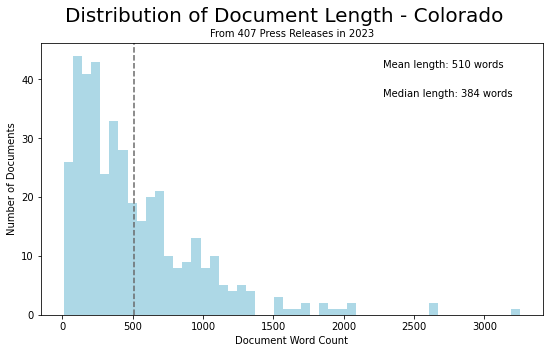

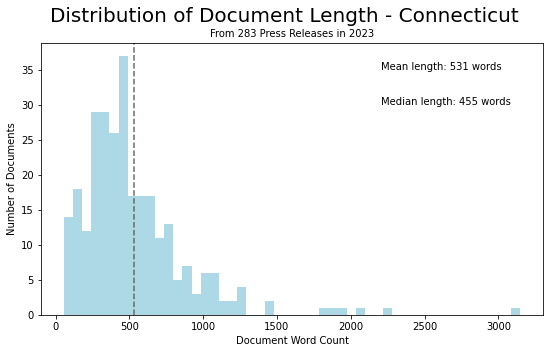

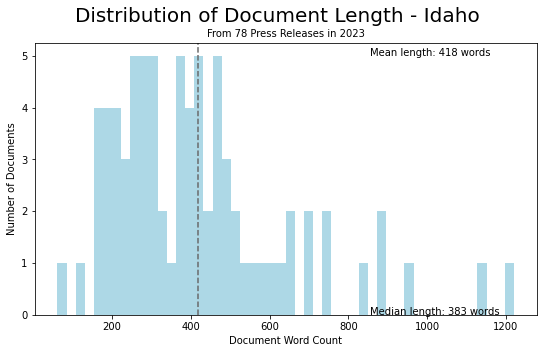

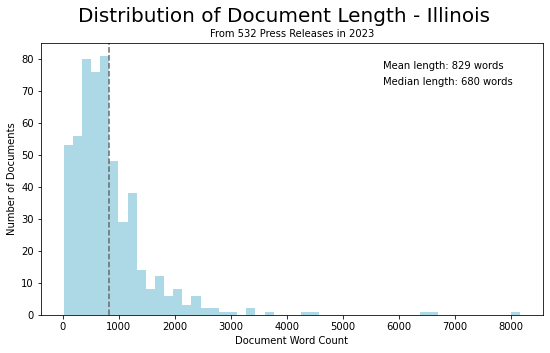

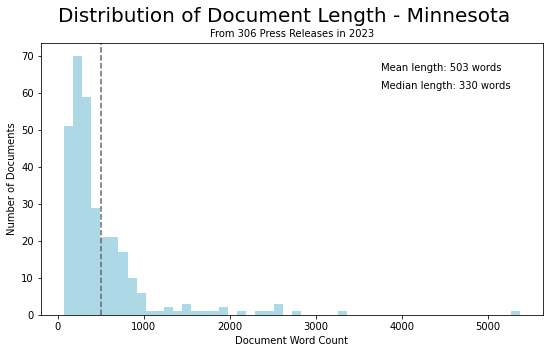

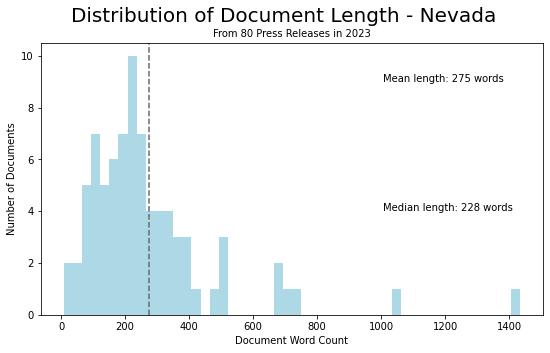

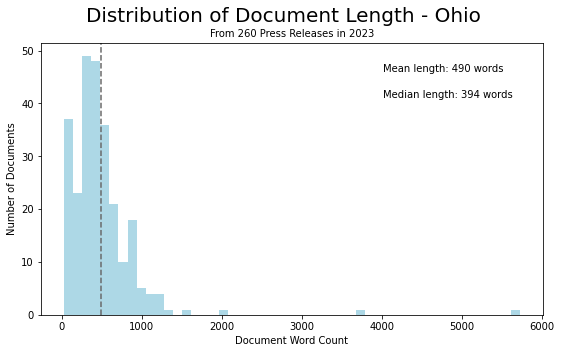

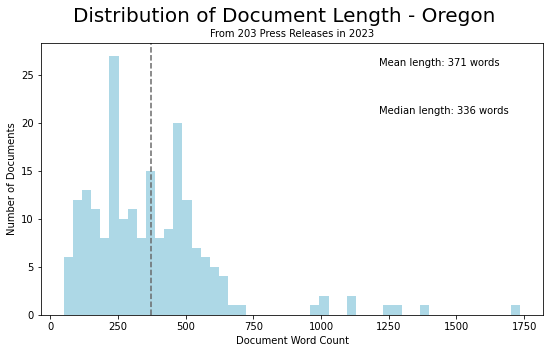

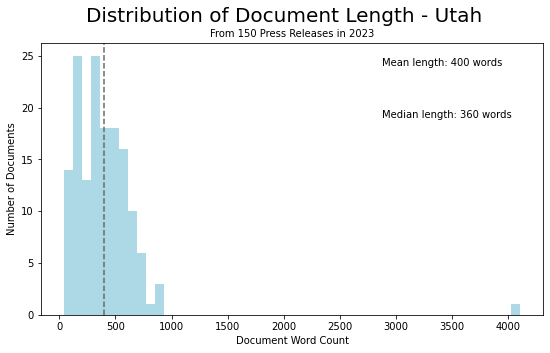

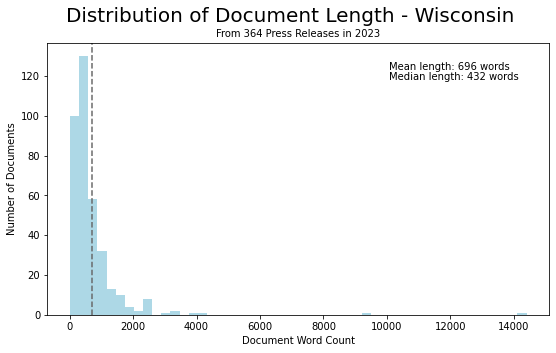

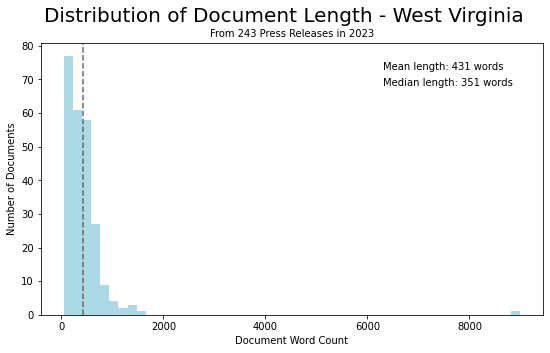

In [16]:
for i, z in zip(df_list, ['Arizona', 'California', 'Colorado', 'Connecticut','Idaho', 'Illinois', 
         'Minnesota', 'Nevada', 'Ohio', 'Oregon', 'Utah', 'Wisconsin', 'West Virginia']):
    plot_distribution(i, z)

In [17]:
# plot_distribution(arizona, 'Arizona')
# plot_distribution(california, 'California')

In [18]:
arizona.word_count.describe()
q3 = arizona.word_count.quantile(q = 0.75)
q3
iq = (arizona.word_count.quantile(q = 0.75)) - arizona.word_count.quantile(q = 0.25)
iq

q3 + (1.5*iq)

count     150.000000
mean      382.300000
std       651.165427
min         4.000000
25%       165.250000
50%       251.000000
75%       359.750000
max      6013.000000
Name: word_count, dtype: float64

359.75

194.5

651.5

In [19]:
# check the outliers
def check_outliers(df, state):
    q3 = df.word_count.quantile(q = 0.75)
    iq = (df.word_count.quantile(q = 0.75)) - df.word_count.quantile(q = 0.25)
    high_outliers = round(q3 + (3*iq))
    outliers = df[df.word_count >= high_outliers].reset_index(drop = True)
    outliers.insert(0,'state', state)
    
    return outliers

In [20]:
check_outliers(arizona, 'Arizona')

,state,title,link,content,date_clean,word_count
0,Arizona,Arizona Governor Katie Hobbs Releases Maguire ...,https://azgovernor.gov/office-arizona-governor...,"Phoenix, AZ – Governor Katie Hobbs announced t...",2023-11-20,1234
1,Arizona,Governor Hobbs Expands Child Care Options for ...,https://azgovernor.gov/office-arizona-governor...,PHOENIX – Governor Katie Hobbs is taking actio...,2023-05-05,1127
2,Arizona,Governor Hobbs Visits Arizona Border for Secon...,https://azgovernor.gov/office-arizona-governor...,This release was originally sent on February 2...,2023-03-06,997
3,Arizona,Governor Katie Hobbs Announces Policy Team Foc...,https://azgovernor.gov/office-arizona-governor...,PHOENIX— Following up on her promise to make a...,2023-01-18,1244
4,Arizona,Governor Hobbs Plans Major Investments to Buil...,https://azgovernor.gov/office-arizona-governor...,Fiscal Year 2024 Executive Budget Released PHO...,2023-01-13,1745
5,Arizona,TRANSCRIPT: Governor Hobbs 2023 State of the S...,https://azgovernor.gov/office-arizona-governor...,"Good afternoon, Chief Justice Brutinel, Secret...",2023-01-09,4882
6,Arizona,In Inaugural State of the State Address Gover...,https://azgovernor.gov/office-arizona-governor...,“The State Of Our State Offers Promise – And W...,2023-01-09,6013
7,Arizona,Governor Hobbs Announces Actions to Modernize ...,https://azgovernor.gov/office-arizona-governor...,Move Comes Moments After Releasing Drastic For...,2023-01-09,1299


In [21]:
for i, z in zip(df_list, ['Arizona', 'California', 'Colorado', 'Connecticut','Idaho', 'Illinois', 
         'Minnesota', 'Nevada', 'Ohio', 'Oregon', 'Utah', 'Wisconsin', 'West Virginia']):
    check_outliers(i, z)

,state,title,link,content,date_clean,word_count
0,Arizona,Arizona Governor Katie Hobbs Releases Maguire ...,https://azgovernor.gov/office-arizona-governor...,"Phoenix, AZ – Governor Katie Hobbs announced t...",2023-11-20,1234
1,Arizona,Governor Hobbs Expands Child Care Options for ...,https://azgovernor.gov/office-arizona-governor...,PHOENIX – Governor Katie Hobbs is taking actio...,2023-05-05,1127
2,Arizona,Governor Hobbs Visits Arizona Border for Secon...,https://azgovernor.gov/office-arizona-governor...,This release was originally sent on February 2...,2023-03-06,997
3,Arizona,Governor Katie Hobbs Announces Policy Team Foc...,https://azgovernor.gov/office-arizona-governor...,PHOENIX— Following up on her promise to make a...,2023-01-18,1244
4,Arizona,Governor Hobbs Plans Major Investments to Buil...,https://azgovernor.gov/office-arizona-governor...,Fiscal Year 2024 Executive Budget Released PHO...,2023-01-13,1745
5,Arizona,TRANSCRIPT: Governor Hobbs 2023 State of the S...,https://azgovernor.gov/office-arizona-governor...,"Good afternoon, Chief Justice Brutinel, Secret...",2023-01-09,4882
6,Arizona,In Inaugural State of the State Address Gover...,https://azgovernor.gov/office-arizona-governor...,“The State Of Our State Offers Promise – And W...,2023-01-09,6013
7,Arizona,Governor Hobbs Announces Actions to Modernize ...,https://azgovernor.gov/office-arizona-governor...,Move Comes Moments After Releasing Drastic For...,2023-01-09,1299


,state,title,link,content,page_scraped,date_clean,word_count
0,California,Read more about WHAT THEY’RE SAYING: Governor ...,https://www.gov.ca.gov/2023/01/13/what-theyre-...,"Published: Jan 13, 2023 SACRAMENTO – State and...",1,2023-01-13,3659
1,California,Read more about Governor Newsom Inaugurated to...,https://www.gov.ca.gov/2023/01/06/governor-new...,"Published: Jan 06, 2023 Watch Governor Newsom’...",1,2023-01-06,2460
2,California,Read more about Twenty-One States Announce His...,https://www.gov.ca.gov/2023/02/21/twenty-state...,"Published: Feb 21, 2023 SACRAMENTO – Today, Ca...",2,2023-02-21,2241
3,California,Read more about Governor Newsom Announces Appo...,https://www.gov.ca.gov/2023/03/30/governor-new...,"Published: Mar 30, 2023 SACRAMENTO – Governor ...",3,2023-03-30,2256
4,California,Read more about Governor Newsom Announces Appo...,https://www.gov.ca.gov/2023/03/29/governor-new...,"Published: Mar 29, 2023 SACRAMENTO – Governor ...",3,2023-03-29,2433
5,California,Read more about Governor Newsom Announces New ...,https://www.gov.ca.gov/2023/05/26/governor-new...,"Published: May 26, 2023 SACRAMENTO – Governor ...",5,2023-05-26,3756
6,California,Read more about Governor Newsom Announces Judi...,https://www.gov.ca.gov/2023/05/19/governor-new...,"Published: May 19, 2023 SACRAMENTO – Governor ...",5,2023-05-19,3570
7,California,Read more about ENDING GUN VIOLENCE IN AMERICA...,https://www.gov.ca.gov/2023/06/12/28th-wtas/,"Published: Jun 12, 2023 SACRAMENTO – Survivors...",6,2023-06-12,2341
8,California,Read more about Governor Newsom Announces Judi...,https://www.gov.ca.gov/2023/10/05/governor-new...,"Published: Oct 05, 2023 SACRAMENTO – Governor ...",10,2023-10-05,2126
9,California,"Read more about Prominent Black, LGBTQ, and El...",https://www.gov.ca.gov/2023/10/02/leaders-prai...,"Published: Oct 02, 2023 SACRAMENTO — Civic lea...",10,2023-10-02,4761


,state,title,link,content,page_scraped,date_clean,word_count
0,Colorado,Gov. Polis & CPW Announce 2023 Human-Bear Conf...,https://www.colorado.gov/governor/news/10586-g...,"DENVER - Today, Governor Polis and Colorado P...",18,2023-08-22,2610
1,Colorado,Gov. Polis & CPW Announce 2023 Human-Bear Conf...,https://www.colorado.gov/governor/news/10586-g...,"DENVER - Today, Governor Polis and Colorado P...",18,2023-08-22,2610
2,Colorado,The Colorado Way: What Coloradans are Saying A...,https://www.colorado.gov/governor/news/9766-co...,"DENVER - Today, Governor Polis, Senate Majorit...",34,2023-03-22,3254


,state,title,link,content,page_scraped,date_clean,word_count
0,Connecticut,Governor Lamont Announces Connecticut Adopting...,https://portal.ct.gov//Office-of-the-Governor/...,"07/26/2023 (HARTFORD, CT) – Govern...",7,2023-07-26,1810
1,Connecticut,Governor Lamont Commits $85 Million in State F...,https://portal.ct.gov//Office-of-the-Governor/...,"06/26/2023 (HARTFORD, CT) – Govern...",9,2023-06-26,1893
2,Connecticut,Governor Lamont Announces $3.7 Million in Stat...,https://portal.ct.gov//Office-of-the-Governor/...,"05/10/2023 (HARTFORD, CT) – Govern...",11,2023-05-10,3148
3,Connecticut,Seven States in Northeast Regional Clean Hydro...,https://portal.ct.gov//Office-of-the-Governor/...,"04/07/2023 (HARTFORD, CT) – The St...",13,2023-04-07,1949
4,Connecticut,"Governor Lamont, Senate President Looney, Spea...",https://portal.ct.gov//Office-of-the-Governor/...,"04/06/2023 (HARTFORD, CT) – Govern...",13,2023-04-06,2228
5,Connecticut,Governor Lamont Announces Connecticut’s Partic...,https://portal.ct.gov//Office-of-the-Governor/...,"02/21/2023 (HARTFORD, CT) – Govern...",16,2023-02-21,2084


,state,title,link,content,date_clean,word_count


,state,title,link,date_clean,content,word_count
0,Illinois,Federal data shows Illinois has highest Medica...,https://gov.illinois.gov/newsroom/press-releas...,2023-12-15,SPRINGFIELD - As the Department of Healthcare ...,6595
1,Illinois,Illinois EPA Invests Over a Half Billion Dolla...,https://gov.illinois.gov/newsroom/press-releas...,2023-08-21,Over $53 Million in Loan Forgiveness Granted t...,8164
2,Illinois,Gov. Pritzker Takes Bill Action,https://gov.illinois.gov/newsroom/press-releas...,2023-08-11,"Today, Governor JB Pritzker took the following...",3372
3,Illinois,Gov. Pritzker Takes Bill Action,https://gov.illinois.gov/newsroom/press-releas...,2023-07-28,"Today, Governor JB Pritzker took the following...",3765
4,Illinois,Gov. Pritzker Takes Bill Action,https://gov.illinois.gov/newsroom/press-releas...,2023-06-30,"Today, Governor JB Pritzker took the following...",4349
5,Illinois,Gov. Pritzker Signs Fifth Balanced Budget,https://gov.illinois.gov/newsroom/press-releas...,2023-06-07,FY24 Budget Makes Transformative Investments i...,3329
6,Illinois,Gov. Pritzker Announces Eighteen Appointments ...,https://gov.illinois.gov/newsroom/press-releas...,2023-03-13,Illinois Commerce CommissionConrad Reddick wil...,2928
7,Illinois,"Gov. Pritzker Proposes Transformative, Generat...",https://gov.illinois.gov/newsroom/press-releas...,2023-02-15,SPRINGFIELD - Building on four years of fiscal...,6376
8,Illinois,Gov. Pritzker Signs Sweeping Reproductive Righ...,https://gov.illinois.gov/newsroom/press-releas...,2023-01-13,Legislation protects health care providers fro...,3092
9,Illinois,Gov. Pritzker Embarks on Second Term with Rene...,https://gov.illinois.gov/newsroom/press-releas...,2023-01-09,"Monday, January 9th, 2023 *Remarks As Prepare...",4435


,state,title,link,content,date_clean,word_count
0,Minnesota,"Governor Walz, Lieutenant Governor Flanagan An...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-10-27,1943
1,Minnesota,"Governor Walz, Lieutenant Governor Flanagan An...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-07-14,1921
2,Minnesota,"Governor Walz, Lieutenant Governor Flanagan An...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-06-30,2545
3,Minnesota,"Governor Walz, Lieutenant Governor Flanagan An...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-06-27,2483
4,Minnesota,"Governor Walz, Lieutenant Governor Flanagan Ce...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-05-31,2153
5,Minnesota,"Governor Walz Announces Nearly 24,000 Minnesot...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz today annou...",2023-05-23,1773
6,Minnesota,Governor Walz State of the State Remarks as Pr...,https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz delivered h...",2023-04-19,2771
7,Minnesota,"During Black History Month, Governor Walz High...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Today, during Black History M...",2023-02-06,1751
8,Minnesota,"Governor Walz, Lieutenant Governor Flanagan Pr...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-01-24,5378
9,Minnesota,"Governor Walz, Lieutenant Governor Flanagan An...",https://mn.gov/governor/newsroom/press-release...,"[ST. PAUL, MN] – Governor Tim Walz and Lieuten...",2023-01-23,2575


,state,title,link,content,date_clean,word_count
0,Nevada,ICYMI: Governor Joe Lombardo Announces Over 70...,https://gov.nv.gov/Newsroom/PRs/2023/2023-11-2...,"Today, Governor Joe Lombardo and the Nevada Go...",2023-11-20,1058
1,Nevada,Governor Lombardo Announces New Boards and Com...,https://gov.nv.gov/Newsroom/PRs/2023/2023-07-1...,"Today, Governor Joe Lombardo announced several...",2023-07-19,1434


,state,link,content,title,date_clean,word_count
0,Ohio,https://governor.ohio.gov/wps/portal/gov/gover...,"(COLUMBUS, Ohio)—Ohio Governor Mike DeWine sig...",Governor Signs Executive Order Awarding Funds ...,2023-10-26,3731
1,Ohio,https://governor.ohio.gov/wps/portal/gov/gover...,"(COLUMBUS, Ohio)—Ohio Governor Mike DeWine tod...",Governor DeWine's 2023 State of the State Address,2023-01-31,5729
2,Ohio,https://governor.ohio.gov/wps/portal/gov/gover...,"(COLUMBUS, Ohio)—The following are an as-prepa...",Governor DeWine's Second Inaugural Address (As...,2023-01-09,2061


,state,title,link,content,date_clean,word_count
0,Oregon,60 Highlights from the First 60 Days: Governor...,https://www.oregon.gov/newsroom/Pages/NewsDeta...,"Salem, OR—Today, Oregon Governor Tina Kotek...",2023-03-10,1397
1,Oregon,Governor Tina Kotek Releases “Mission Focused”...,https://www.oregon.gov/newsroom/Pages/NewsDeta...,"Plan will build more housing, reduce homeless...",2023-01-31,1246
2,Oregon,La gobernadora Tina Kotek hace públicas sus re...,https://www.oregon.gov/newsroom/Pages/NewsDeta...,"El plan construirá más viviendas, reducirá el...",2023-01-31,1736
3,Oregon,Governor Tina Kotek Announces Key Hires to Lea...,https://www.oregon.gov/newsroom/Pages/NewsDeta...,New Office Structure Aims to Strengthen Partn...,2023-01-11,1294


,state,title,link,content,page_scraped,date_clean,word_count
0,Utah,Gov. Spencer Cox presents Governor’s Award for...,https://governor.utah.gov/2023/10/12/gov-spenc...,"SALT LAKE CITY (Oct. 12, 2023) – Gov. Spencer ...",6,2023-10-12,4109


,state,title,link,content,date_clean,word_count
0,Wisconsin,2023 Roundup: Gov. Evers Completes Annual 72-C...,https://content.govdelivery.com/accounts/WIGOV...,MADISON — Gov. Tony Evers today announced that...,2023-12-28,14400
1,Wisconsin,2023 Roundup: Gov. Evers Highlights 2023 Accom...,https://content.govdelivery.com/accounts/WIGOV...,MADISON — Gov. Tony Evers today celebrated his...,2023-12-26,9253
2,Wisconsin,Gov. Evers Takes Action on 48 Bills,https://content.govdelivery.com/accounts/WIGOV...,MADISON — Gov. Tony Evers took action on 48 bi...,2023-12-06,2395
3,Wisconsin,Gov. Evers Slams Senate Republicans for Contin...,https://content.govdelivery.com/accounts/WIGOV...,MADISON — Gov. Tony Evers slammed Republicans ...,2023-10-17,2437
4,Wisconsin,Gov. Evers Calls Legislature into Special Sess...,https://content.govdelivery.com/accounts/WIGOV...,MILWAUKEE — Gov. Tony Evers today signed Execu...,2023-08-08,2339
5,Wisconsin,Gov. Evers Signs 2023-25 Biennial Budget Makin...,https://content.govdelivery.com/accounts/WIGOV...,MADISON— Gov. Tony Evers today enacted the 202...,2023-07-05,3390
6,Wisconsin,"Gov. Evers Celebrates Public Schools Week, Hig...",https://content.govdelivery.com/accounts/WIGOV...,MADISON — Gov. Tony Evers today celebrated the...,2023-02-27,3035
7,Wisconsin,"ICYMI: Gov. Evers Visits Racine, Eau Claire, a...",https://content.govdelivery.com/accounts/WIGOV...,"MADISON — Gov. Tony Evers, together with Wisco...",2023-02-21,2568
8,Wisconsin,Gov. Evers Delivers on Promise of 10-Percent M...,https://content.govdelivery.com/accounts/WIGOV...,"MADISON — Gov. Tony Evers tonight, during his ...",2023-02-15,2498
9,Wisconsin,Gov. Evers Proposes to Send 20 Percent of Stat...,https://content.govdelivery.com/accounts/WIGOV...,"MADISON — Gov. Tony Evers tonight, during his ...",2023-02-15,2400


,state,title,link,content,date_clean,word_count
0,West Virginia,Gov. Justice delivers his 2023 West Virginia S...,https://governor.wv.gov/News/press-releases/20...,"VIEW PHOTO ALBUMCHARLESTON, WV– Gov. Jim Justi...",2023-01-11,8996


In [22]:
### Manually review

In [23]:
# az_outliers = check_outliers(arizona, 'arizona')

In [24]:
# reviewed all - no abnormalities
# az_outliers.content[7]

In [25]:
# ca_outliers = check_outliers(california, 'california')
# ca_outliers

In [26]:
# no concerns
# ca_outliers.content[10]

In [27]:
# co_outliers = check_outliers(colorado, 'colorado')
# co_outliers

In [28]:
# co had some duplicates, so let's remove
colorado_cl = colorado.drop_duplicates()

In [29]:
colorado.shape
colorado_cl.shape

(407, 6)

(370, 6)

In [30]:
# co_outliers_cl = check_outliers(colorado_cl, 'colorado')
# co_outliers_cl

In [31]:
# ct_outliers = check_outliers(connecticut, 'conn')
# ct_outliers

In [32]:
# no issues 
#ct_outliers.content[5]

In [33]:
# id_outliers = check_outliers(idaho, 'idaho')
# id_outliers
# no outliers

In [44]:
il_outliers = check_outliers(illinois, 'illinois')
# il_outliers 

In [35]:
# il_outliers.content[2] 

# # 0 has press release copied twice
# # 2 has press release copied twice

In [45]:
# clean in the main df
pattern = r'For more information, please visit HFS\' online information center at Medicaid.illinois.gov.'
input_string = il_outliers.content[0] 
match = re.search(pattern, input_string)
clean_string = input_string[:match.end()]
# clean_string
LINK = il_outliers.link.iloc[0]

# add to df 
illinois.loc[illinois.link == LINK, 'content'] = clean_string

In [46]:
# clean in the main df
pattern = r'contract after four consecutive bids to provide the same service to a single agency. Action: Signed Effective: January 1, 2024'
input_string = il_outliers.content[2] 
match = re.search(pattern, input_string)
clean_string = input_string[:match.end()]
# clean_string
LINK = il_outliers.link.iloc[2]

# add to df 
illinois.loc[illinois.link == LINK, 'content'] = clean_string

In [ ]:
# mn_outliers = check_outliers(minnesota, 'min')
# mn_outliers

In [ ]:
# mn_outliers.content[12] # no issues

In [ ]:
# nv_outliers = check_outliers(nevada, 'nevada')
# nv_outliers 

In [ ]:
# nv_outliers.content[1] # no issues

In [ ]:
# oh_outliers = check_outliers(ohio, 'ohio')
# oh_outliers 

In [ ]:
# oh_outliers.content[2] # no issues

In [47]:
or_outliers = check_outliers(oregon, 'oregon')
# or_outliers 

In [ ]:
# or_outliers.content[2]  

# 2 - spanish translation - probably drop? 

In [48]:
def detect_language(line):
    try: 
        langs = detect_langs(line) 
        for item in langs: 
            return item.lang
    except: return "err", 0.0 

In [49]:
detect_language(or_outliers.content[2])

'es'

In [50]:
oregon['language'] = [detect_language(i) for i in oregon.content]

In [51]:
# the only one with spanish. Since we already know it's a duplicate, we'll drop it 
oregon[oregon.language == 'es']

,title,link,content,date_clean,word_count,language
189,La gobernadora Tina Kotek hace públicas sus re...,https://www.oregon.gov/newsroom/Pages/NewsDeta...,"El plan construirá más viviendas, reducirá el...",2023-01-31,1736,es


In [52]:
oregon_cl = oregon.drop([189], axis = 0).copy()

In [53]:
oregon_cl = oregon_cl.drop(columns='language')

In [ ]:
# ut_outliers = check_outliers(utah, 'utah')
# ut_outliers

In [ ]:
# ut_outliers.content[0]
# no issues

In [ ]:
# wi_outliers = check_outliers(wisconsin, 'wisc')
# wi_outliers 

In [ ]:
# wi_outliers.content[14]
# no issues

In [ ]:
# wv_outliers = check_outliers(west_virginia, 'wv')
# wv_outliers  

In [ ]:
# # wv_outliers.content[0]
# no issues

## Data Viz

In [54]:
state_dict = {'AZ': arizona.shape[0], 'CA': california.shape[0], 'CO': colorado_cl.shape[0], 
              'CT': connecticut.shape[0], 'ID': idaho.shape[0], 'IL': illinois.shape[0],
              'MN': minnesota.shape[0], 'NV': nevada.shape[0], 'OH': ohio.shape[0], 'OR': oregon_cl.shape[0],
             'UT': utah.shape[0], 'WI': wisconsin.shape[0], 'WV': west_virginia.shape[0]}

count_df = pd.DataFrame(list(state_dict.items()), columns = ['State', 'Count'])
count_df

,State,Count
0,AZ,150
1,CA,608
2,CO,370
3,CT,283
4,ID,78
5,IL,532
6,MN,306
7,NV,80
8,OH,260
9,OR,202


<BarContainer object of 13 artists>

Text(0.5, 1.0, 'Count of Press Releases by State for 2023\n')

Text(0.5, 0, '\nState')

Text(0, 0.5, 'Count of Press Releases')

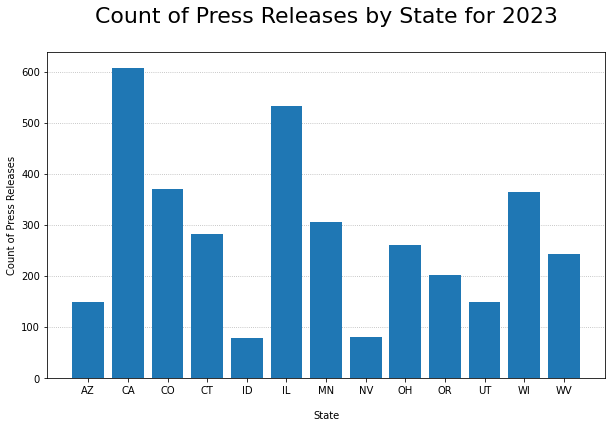

In [57]:
fig, ax = plt.subplots(figsize = (10,6))
ax.yaxis.grid(ls = ':')
ax.bar(count_df.State, count_df.Count)
ax.set_axisbelow(b= True)
ax.set_title('Count of Press Releases by State for 2023\n', fontsize = 22)
ax.set_xlabel('\nState')
ax.set_ylabel('Count of Press Releases')
# fig.savefig('count_bar_chart.jpg')

In [56]:
count_df.Count.describe()

count     13.000000
mean     278.923077
std      160.564349
min       78.000000
25%      150.000000
50%      260.000000
75%      364.000000
max      608.000000
Name: Count, dtype: float64

## Create TFIDF 

### Assess doc frequency 

In [58]:
# explore min_doc frequency options of 1-30
term_count = []

for i in range(10, 31):
    vectorizer = CountVectorizer(stop_words='english', min_df=i)
    dtm = vectorizer.fit_transform(arizona.content)
    length = dtm.shape[1]
    term_count.append(length)

min_df = pd.DataFrame(data = {'Min Doc': range(10,31),
                              'Term Count': term_count})

Text(0.5, 1.0, 'Minimum Document Frequency and Resulting Term Count - Arizona')

Text(0, 0.5, 'Term Count')

Text(0.5, 0, 'Minimum Document Frequency')

([<matplotlib.axis.XTick at 0x7fc02a671b20>,
 [Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30')])

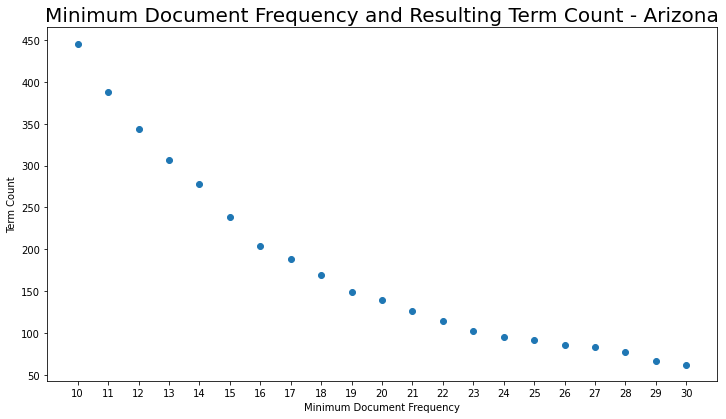

In [59]:
fig, ax = plt.subplots(figsize=(12,6.5))
# ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
plt.title('Minimum Document Frequency and Resulting Term Count - Arizona', size = 20)
plt.ylabel('Term Count')
plt.xlabel('Minimum Document Frequency')
plt.xticks(range(10,31))
#plt.savefig('min_doc_freq.png')

In [60]:
def explore_min_df(df, state):
    # explore min_doc frequency options of 1-30
    term_count = []

    for i in range(5, 26):
        vectorizer = CountVectorizer(stop_words='english', min_df=i)
        dtm = vectorizer.fit_transform(df.content)
        length = dtm.shape[1]
        term_count.append(length)

    min_df = pd.DataFrame(data = {'Min Doc': range(5,26),
                                  'Term Count': term_count})
    
    fig, ax = plt.subplots(figsize=(12,6.5))
    # ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
    ax.scatter(x = min_df['Min Doc'], y = min_df['Term Count'])
    plt.title(f'From {str(df.shape[0])} Press Releases in 2023') 
    plt.suptitle(f'Minimum Document Frequency and Resulting Term Count - {state}', size = 15)
    plt.ylabel('Term Count')
    plt.xlabel('Minimum Document Frequency')
    plt.xticks(range(5,26))

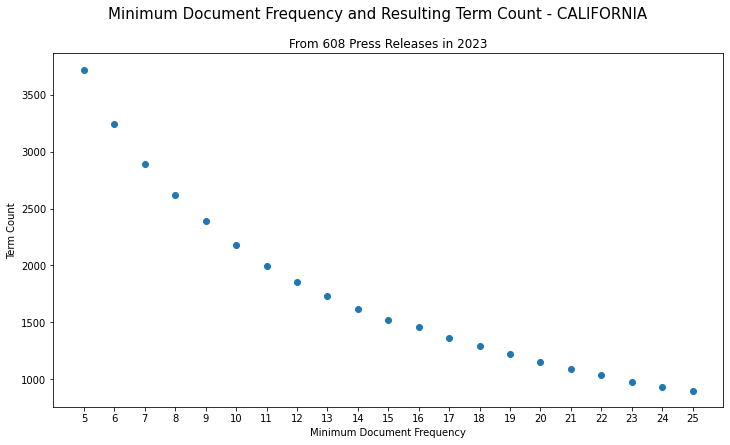

In [61]:
explore_min_df(california, 'CALIFORNIA')

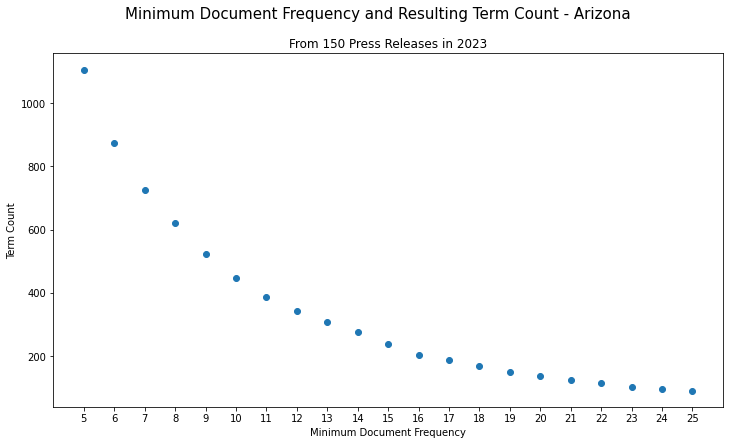

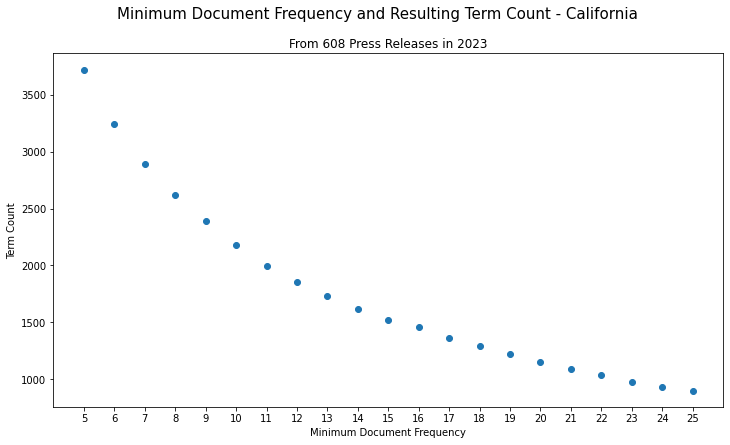

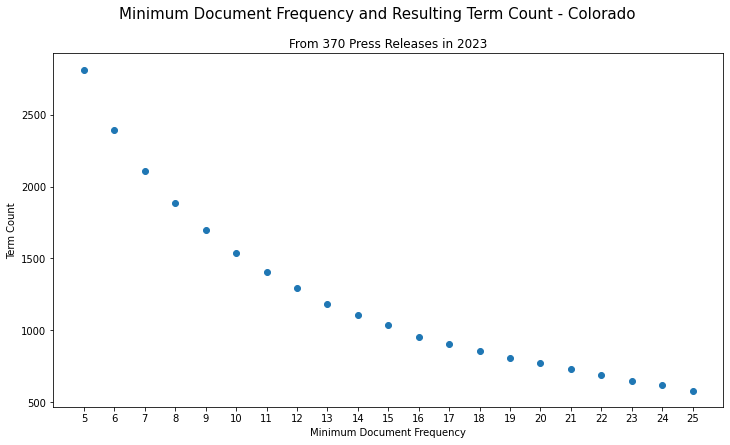

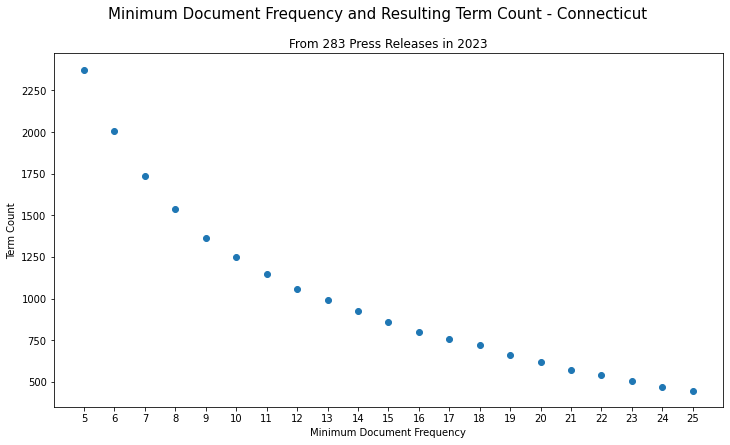

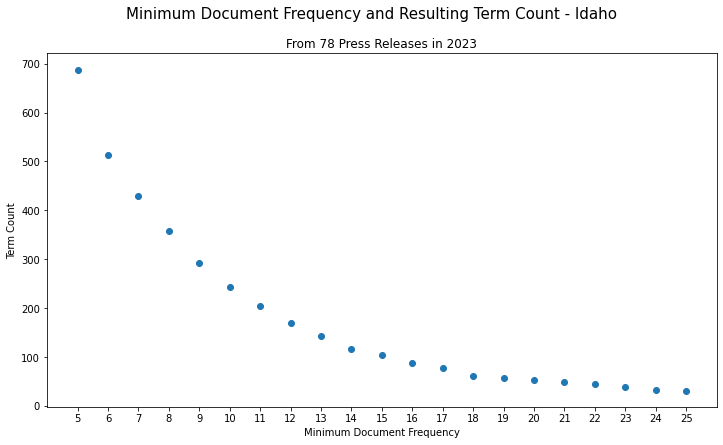

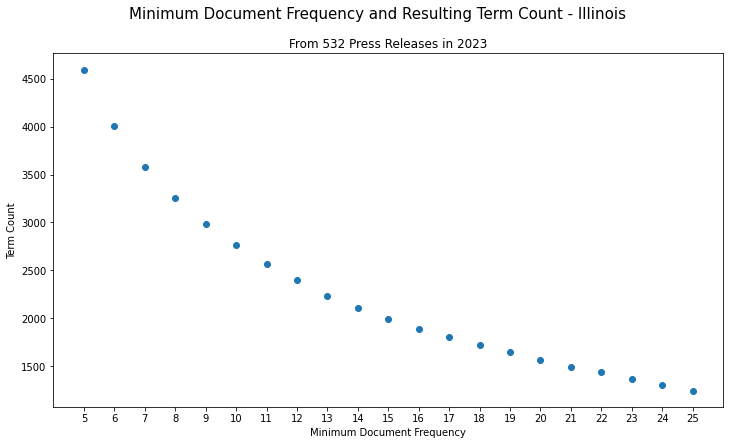

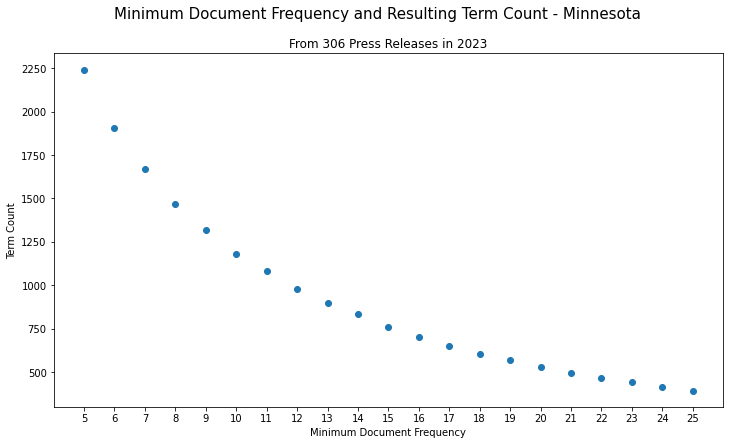

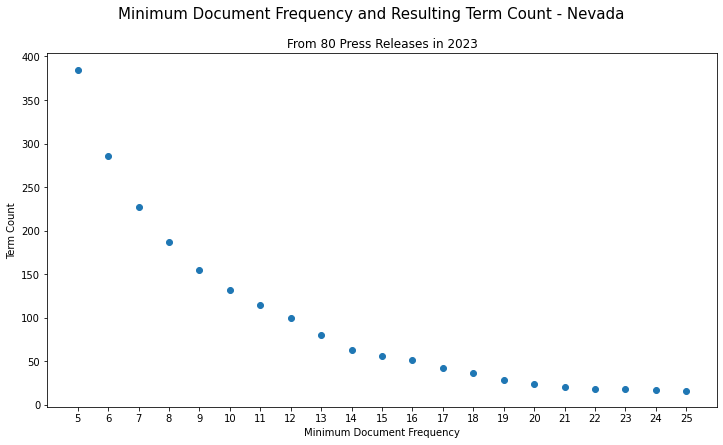

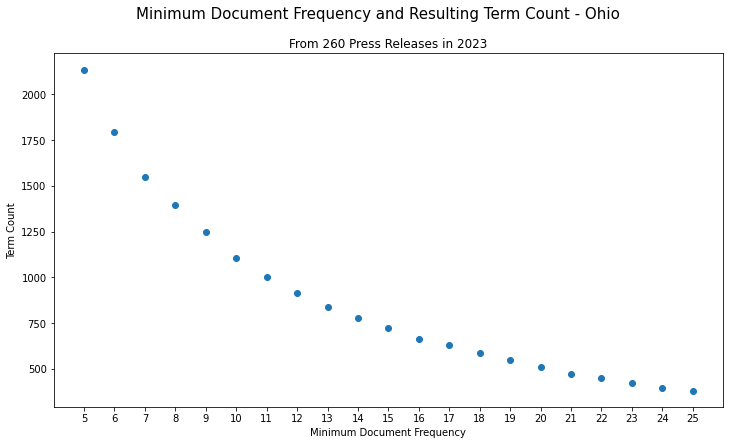

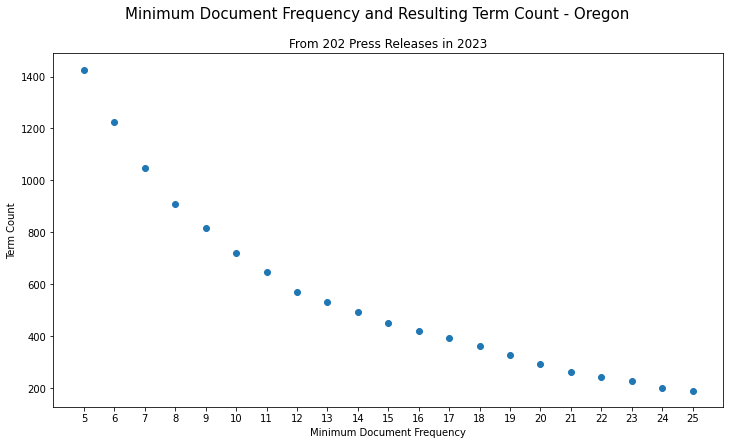

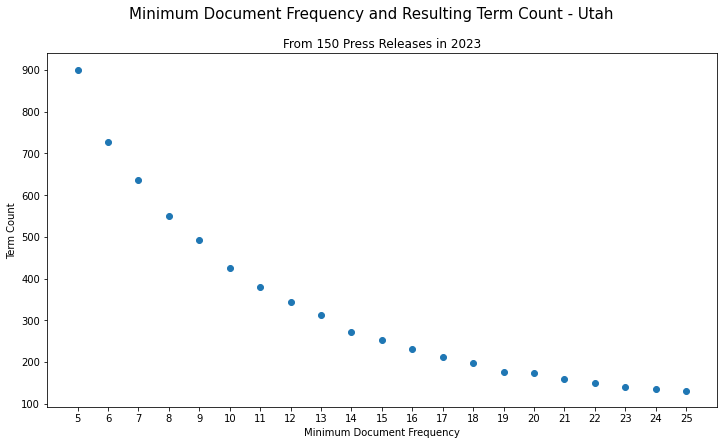

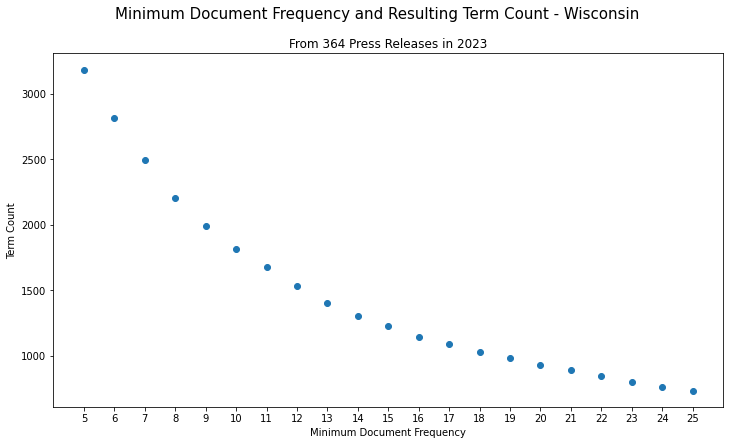

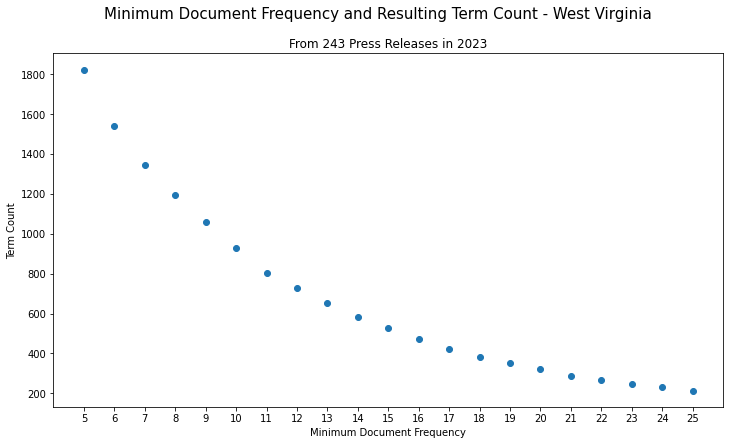

In [62]:
# do for all
df_list = [arizona, california, colorado_cl, connecticut, idaho, illinois, minnesota, nevada, ohio, oregon_cl,
          utah, wisconsin, west_virginia]

for i, z in zip(df_list, ['Arizona', 'California', 'Colorado', 'Connecticut','Idaho', 'Illinois', 
         'Minnesota', 'Nevada', 'Ohio', 'Oregon', 'Utah', 'Wisconsin', 'West Virginia']):
    explore_min_df(i, z)

In [65]:
# Arizona: 9     keeps it at 500 terms
# California:  11   
# Colorado:  13
# Connecticut: 12
# Idaho: 6   --- really low sample of 78 docs; 6 is the highest to keep term count above 500
# Illinois: 12 
# Minnesota: 11
# Nevada: not sure -- really low same of 80 docs; 5 doesn't even get to 500 terms 
# Ohio: 11 
# Oregon: 7
# Utah: 9 
# Wisconsin:  12
# West Virginia:  11 

# After a review of them all, let's do 5 mdf for small samples and 11 for the others 
# arizona, idaho, oregon, utah -  5 

### + basic stopwords

In [63]:
# define functions for testing hyper parameter easily
def convert_to_term_df(dtm_input, tfidf_vectorizer_input):
    content_index = pd.DataFrame(dtm_input.toarray()).head()
    term_indices = {index: term for term, index in tfidf_vectorizer_input.vocabulary_.items()}
    colterms = [term_indices[i] for i in range(dtm_input.shape[1])]
    final_df = pd.DataFrame(dtm_input.toarray(), columns=colterms)

    return final_df

In [64]:
# vectorize with stop words only 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
dtm = tfidf_vectorizer.fit_transform(arizona.content)
dtm.shape # (150, 1106)

(150, 1106)

In [65]:
df = convert_to_term_df(dtm, tfidf_vectorizer)
df.head()

,000,10,100,11,12,15,18,19,20,2017,...,working,workplace,works,world,yavapai,year,years,yesterday,young,yuma
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.105670,0.000000,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.050187,0.057343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114793,0.0,0.0,0.0,0.0,0.000000,0.035646,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.044589,0.000000,0.0,0.0,0.0
4,0.060476,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [66]:
# https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score
def get_top_terms(dtm_input, tfidf_vectorizer_input, num):
    importance = np.argsort(np.asarray(dtm_input.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer_input.get_feature_names_out())
    return tfidf_feature_names[importance[: num]]

In [67]:
get_top_terms(dtm, tfidf_vectorizer, 10)

array(['arizona', 'governor', 'hobbs', 'state', 'water', 'county',
       'border', 'katie', 'public', 'said'], dtype=object)

### +words only

In [68]:
# vectorzie with stop words and words only (remove numbers and must be 3 letters minimum)
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', min_df=5, token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm2 = tfidf_vectorizer2.fit_transform(arizona.content)
dtm2.shape #(150, 1074)

(150, 1074)

In [69]:
get_top_terms(dtm2, tfidf_vectorizer2, 10)
df2 = convert_to_term_df(dtm2, tfidf_vectorizer2)
df2.head()

array(['arizona', 'governor', 'hobbs', 'state', 'water', 'county',
       'border', 'katie', 'public', 'said'], dtype=object)

,ability,able,abortion,abuse,academy,access,accessibility,accountability,accountable,achieve,...,working,workplace,works,world,yavapai,year,years,yesterday,young,yuma
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.069965,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.106036,0.00000,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0
2,0.000000,0.056097,0.0,0.0,0.0,0.042225,0.0,0.000000,0.0,0.0,...,0.117156,0.0,0.0,0.0,0.0,0.000000,0.03638,0.0,0.0,0.0
3,0.061717,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.044609,0.00000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0


### + bigrams

In [73]:
# vectorize with bigrams
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', min_df=5, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm3 = tfidf_vectorizer3.fit_transform(arizona.content)
dtm3.shape  # (150, 1331)
# larger number

(150, 1331)

In [74]:
get_top_terms(dtm3, tfidf_vectorizer3, 10)
df3 = convert_to_term_df(dtm3, tfidf_vectorizer3)
df3.head()

array(['arizona', 'governor', 'hobbs', 'state', 'governor hobbs', 'water',
       'county', 'border', 'katie', 'katie hobbs'], dtype=object)

,ability,able,abortion,abuse,academy,access,accessibility,accountability,accountable,achieve,...,world,yavapai,yavapai county,year,year budget,years,years experience,yesterday,young,yuma
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.068964,0.0,0.0,...,0.0,0.0,0.0,0.104518,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.053759,0.0,0.0,0.0,0.040465,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.034863,0.0,0.0,0.0,0.0
3,0.056688,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.040974,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### + maxdf 

In [75]:
def explore_max_df(df, state, min_df_value):
    term_count = []
    
    for i in [0.75, 0.8, 0.85, 0.9, 0.95]:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df_value, max_df=i, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
        dtm = tfidf_vectorizer.fit_transform(df.content)
        length = dtm.shape[1]
        term_count.append(length)

    max_df = pd.DataFrame(data = {'Max Doc': [0.75, 0.8, 0.85, 0.9, 0.95],
                                  'Term Count': term_count})
    
    fig, ax = plt.subplots(figsize=(12,6.5))
    # ax.plot(range(1,26), min_df['Term Count'], linewidth = 2.5, color = 'green')
    ax.scatter(x = max_df['Max Doc'], y = max_df['Term Count'])
    #plt.plot(x = max_df['Max Doc'], y = max_df['Term Count'])
    plt.title(f'From {str(df.shape[0])} Press Releases in 2023') 
    plt.suptitle(f'Maximum Document Frequency and Resulting Term Count - {state}', size = 15)
    plt.ylabel('Term Count')
    plt.xlabel('Max Document Frequency')
    

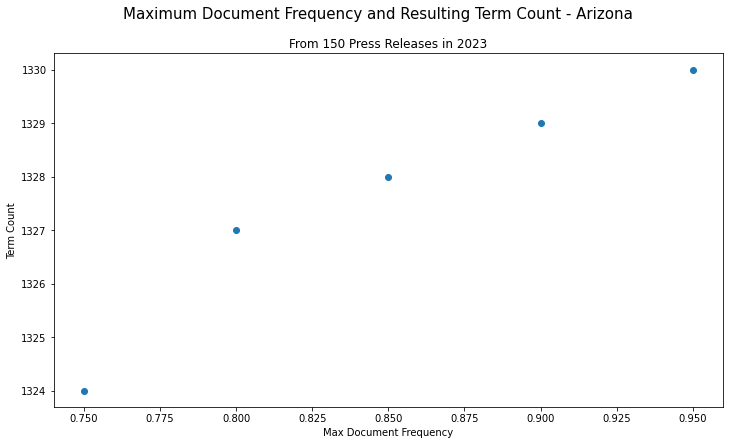

In [76]:
explore_max_df(arizona, 'Arizona', 5) 

In [77]:
df_list_sm = [arizona, idaho, nevada, ohio, oregon_cl, utah]
df_list_lg = [california, colorado_cl, connecticut, illinois, minnesota, wisconsin, west_virginia]

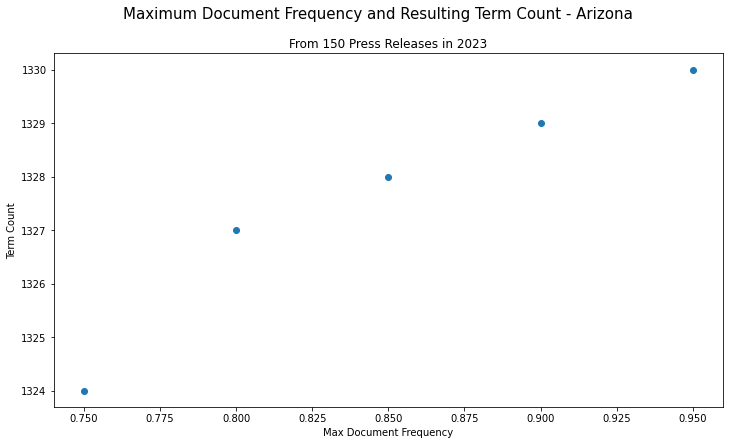

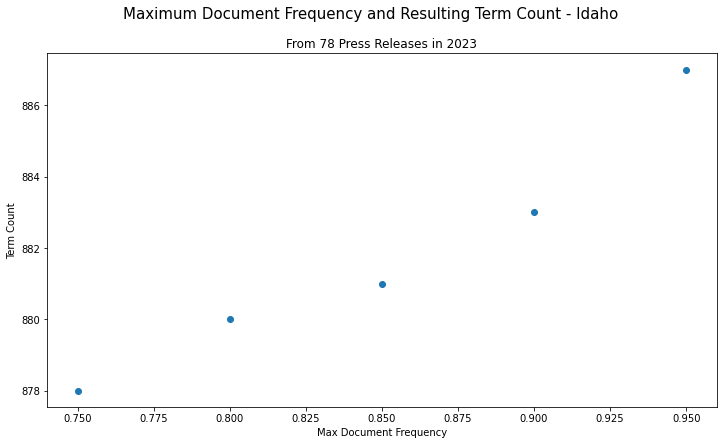

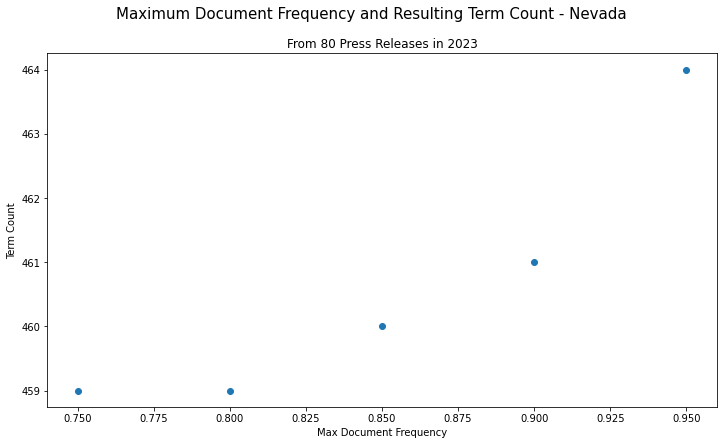

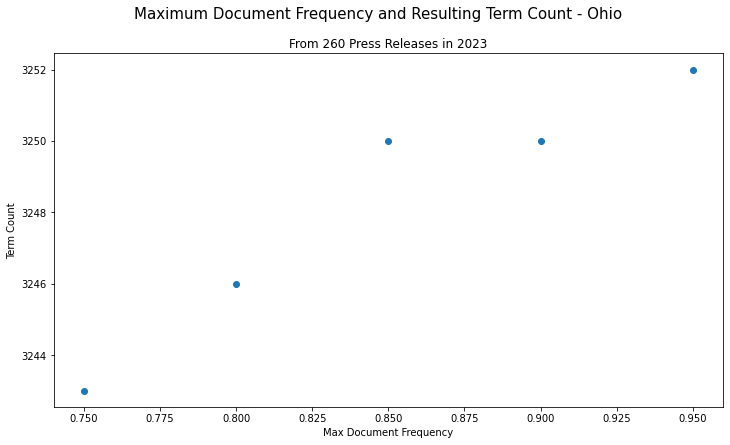

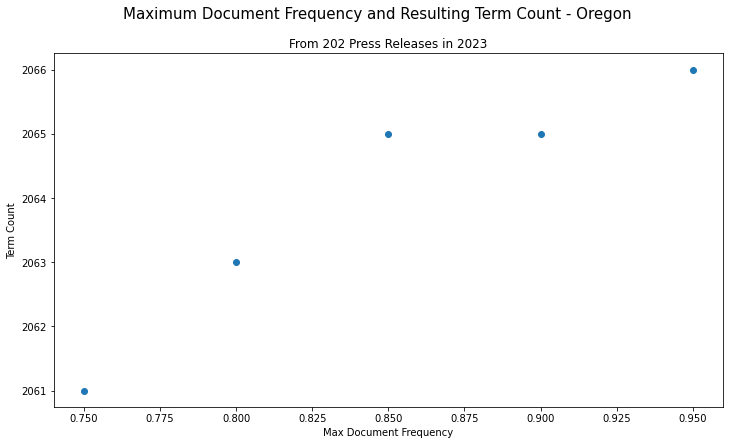

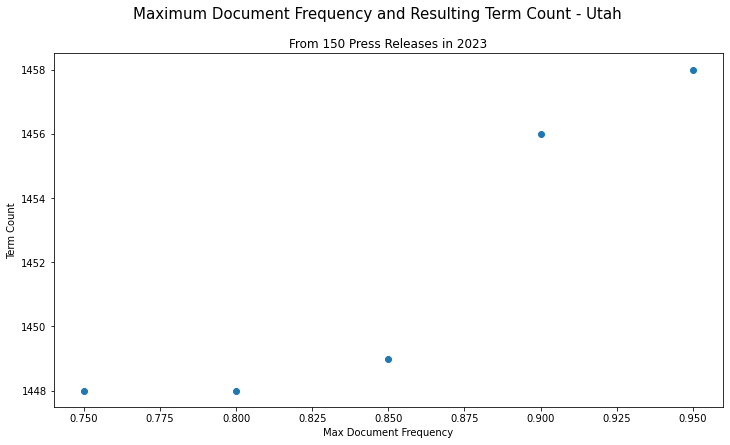

In [78]:
for i, z in zip(df_list_sm, ['Arizona', 'Idaho', 'Nevada', 'Ohio', 'Oregon', 'Utah']):
    explore_max_df(i, z, 5)

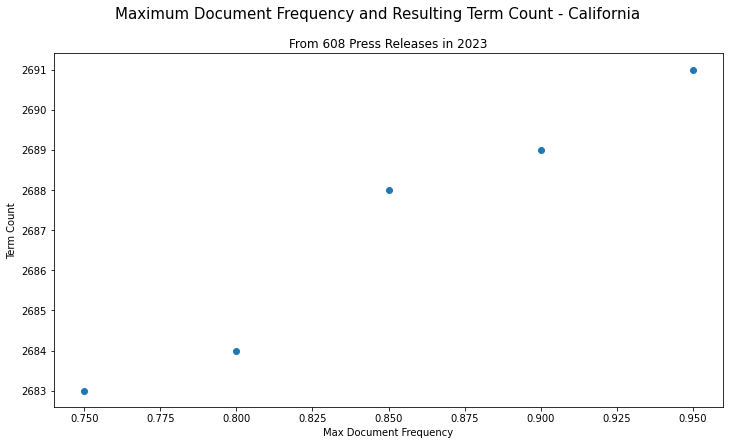

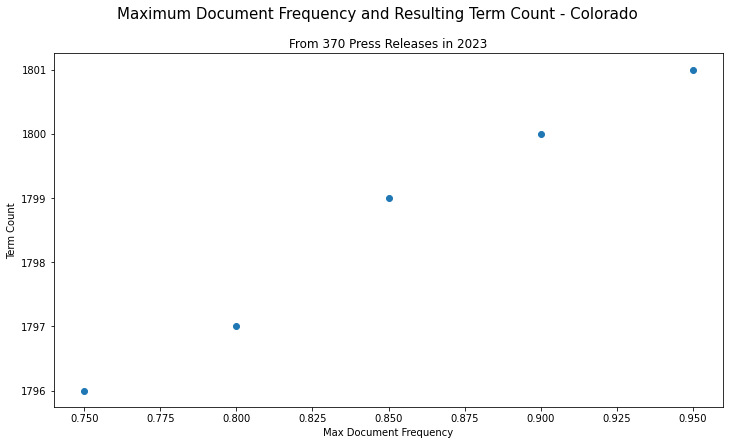

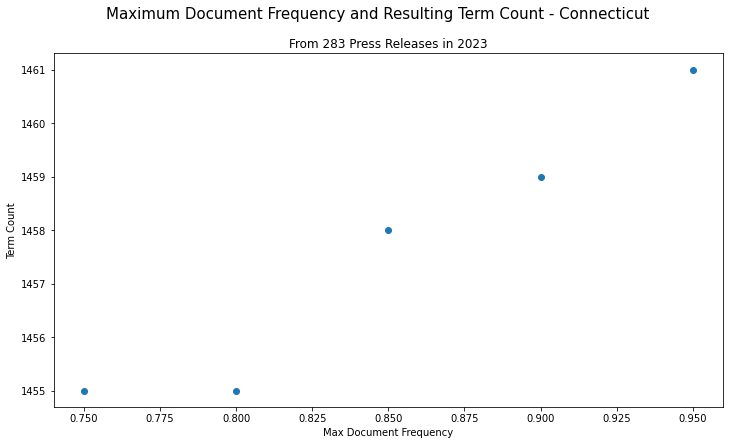

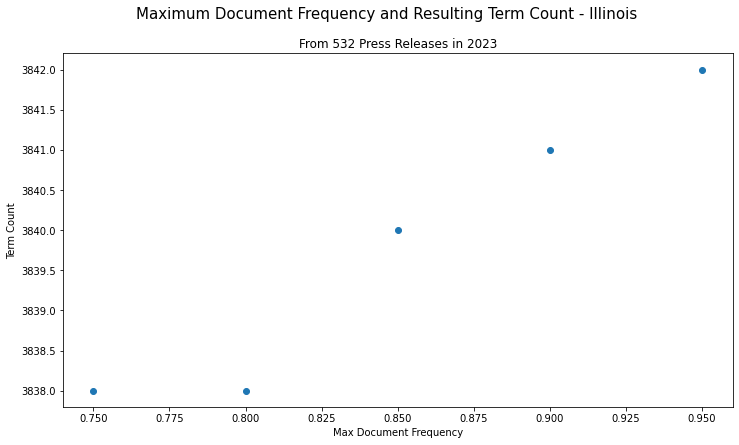

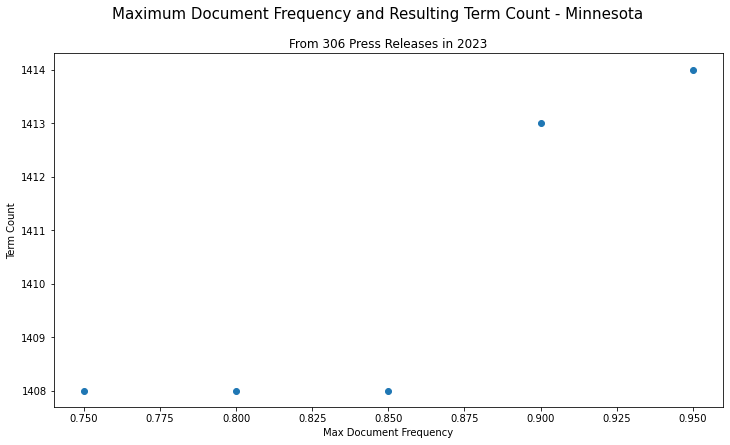

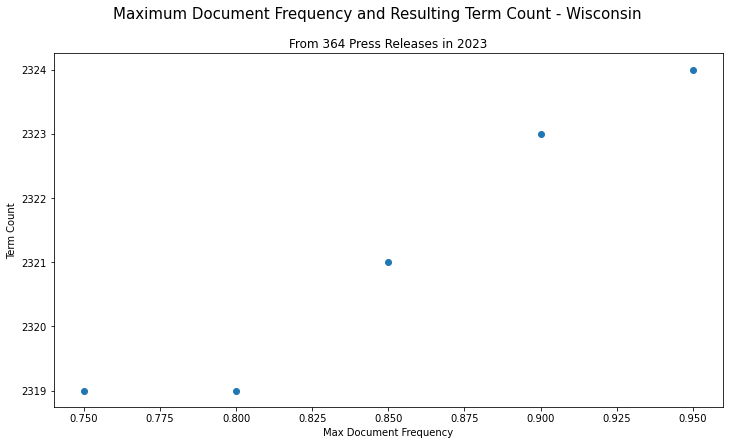

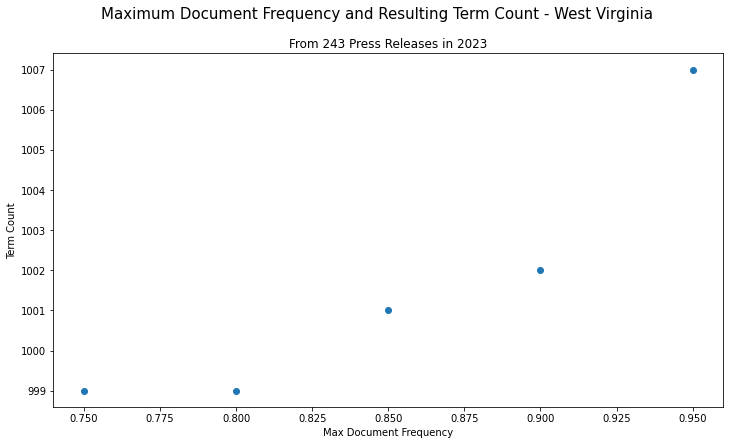

In [79]:
for i, z in zip(df_list_lg, ['California', 'Colorado', 'Connecticut', 'Illinois', 
         'Minnesota', 'Wisconsin', 'West Virginia']):
    explore_max_df(i, z, 11)

In [80]:
# 0.8 should work for everything as long as smaller sample size has 5 min df 

In [70]:
tfidf_vectorizer4 = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b')
dtm4 = tfidf_vectorizer4.fit_transform(arizona.content)
dtm4.shape  # (50, 2589) # removed words

(150, 1327)

In [71]:
get_top_terms(dtm4, tfidf_vectorizer4, 10)  # need stop word processing
df4 = convert_to_term_df(dtm4, tfidf_vectorizer4)
df4.head() 

array(['state', 'governor hobbs', 'water', 'county', 'border', 'katie',
       'katie hobbs', 'public', 'governor katie', 'said'], dtype=object)

,ability,able,abortion,abuse,academy,access,accessibility,accountability,accountable,achieve,...,world,yavapai,yavapai county,year,year budget,years,years experience,yesterday,young,yuma
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.069,0.0,0.0,...,0.0,0.0,0.0,0.104572,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.000000,0.055254,0.0,0.0,0.0,0.041591,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.035833,0.0,0.0,0.0,0.0
3,0.057033,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.041223,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### + normalization - l1 

In [72]:
tfidf_vectorizer5 = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.8, ngram_range=(1,2), 
                                    token_pattern= r'\b[a-zA-Z]{3,}\b', norm = 'l1')
dtm5 = tfidf_vectorizer5.fit_transform(arizona.content)
dtm5.shape  # (150, 1327) # big decrease 

(150, 1327)

In [73]:
get_top_terms(dtm5, tfidf_vectorizer5, 10)  # need stop word processing
df5 = convert_to_term_df(dtm5, tfidf_vectorizer5)
df5.head() 

array(['state', 'veto', 'veto letters', 'governor hobbs', 'letters',
       'june', 'county', 'action', 'signed', 'water'], dtype=object)

,ability,able,abortion,abuse,academy,access,accessibility,accountability,accountable,achieve,...,world,yavapai,yavapai county,year,year budget,years,years experience,yesterday,young,yuma
0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.011141,0.0,0.0,...,0.0,0.0,0.0,0.016885,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.00000,0.005076,0.0,0.0,0.0,0.003821,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.003292,0.0,0.0,0.0,0.0
3,0.00748,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.005407,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### + custom stop words 

In [77]:
# https://aparnamishra144.medium.com/how-to-add-custom-stopwords-and-remove-them-from-text-in-nlp-50d342cfafff
az_stpwds = ['arizona', 'governor','governor hobbs', 'state', 'county', 'said', 'katie', 'hobbs', 'today',
            'arizonans']
ca_stpwds = ['california', 'governor', 'californians', 'state', 'county', 'said',]
co_stpwds = ['colorado', 'governor', 'state' ,'coloradans', 'state', 'county', 'said',]
ct_stpwds = ['connecticut', 'governor', 'state', 'county', 'said',]
id_stpwds = ['idaho', 'governor', 'county', 'office', 'today', 'state', 'county', 'said']
il_stpwds = ['illinois', 'governor', 'county', 'said', 'state', 'county', 'today']
mn_stpwds = ['minnesota', 'governor', 'said', 'flanagan', 'county', 'minnesotans', 'said', 'state', 'today']
nv_stpwds = ['nevada', 'governor', 'county', 'office', 'today', 'said', 'session', 'department', 'state']
oh_stpwds = ['ohio', 'governor', 'said', 'state', 'county', 'today']
or_stpwds = ['oregon', 'governor', 'said', 'county', 'state', 'today']
ut_stpwds = ['governor', 'said', 'county', 'cox', 'gov', 'utah', 'state', 'jan', 'state', 'today']
wi_stpwds = ['wisconsin', 'governor', 'county', 'state', 'said', 'today']
wv_stpwds = ['west', 'virginia', 'said', 'year', 'justice', 'gov', 'county', 'state', 'today']


In [78]:
## Create dtm function 
def create_tfidf(df, min_df_value, stop_list):
    stpwrds = nltk.corpus.stopwords.words('english')
    stpwrds.extend(stop_list)
    tfidf_vectorizer = TfidfVectorizer(stop_words=stpwrds, min_df=min_df_value, max_df=0.8, ngram_range=(1,2),
                                       token_pattern= r'\b[a-zA-Z]{3,}\b')
    dtm = tfidf_vectorizer.fit_transform(df.content)
    return dtm, tfidf_vectorizer

## Isolate Top Terms & PCA 

5 mdf --> df_list_sm = [arizona, idaho, nevada, ohio, oregon_cl, utah] 

11 mdf --> df_list_lg = [california, colorado_cl, connecticut, illinois, minnesota, wisconsin, west_virginia]

In [79]:
def print_state_top_terms(df, min_df_value, stopwords, state):
    result = create_tfidf(df, min_df_value, stopwords)
    dtm = result[0]
    tfidfvect = result[1]
    terms = get_top_terms(dtm, tfidfvect, 15)
    return (f'{state} top terms: {terms}')

In [81]:
def print_pca(df, min_df_value, stopwords, state):
    # create tfidf 
    result = create_tfidf(df, min_df_value, stopwords)
    dtm = result[0]
    tfidfvect = result[1]
    
    #conduct PCA 
    x = convert_to_term_df(dtm, tfidfvect)
    pca = PCA()
    pca.fit(x)
    
    # examine variance
    pc_variance = list(pca.explained_variance_ratio_)
    pc_variance_top5 = sum(pc_variance[:5])
    print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      f' of variance in full dataset for {state}')
    pc_variance_top10 = sum(pc_variance[:10])
    print('First 10 PC explain '+ str(round(pc_variance_top10, 4)) + 
      f' of variance in full dataset for {state}')
   
    # view PCs
    factor_loadings = pca.components_  #extract the component loadings
    matrix = np.transpose(factor_loadings) #flip the rows and cols 
    fl = pd.DataFrame(data = matrix, index = x.columns)
    top_10 = fl.iloc[:,0:10]
    top_10.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
    PC1_20 = top_10.sort_values(by = 'PC1', ascending = False).head(20)
    PC2_20 = top_10.sort_values(by = 'PC2', ascending = False).head(20)
    PC3_20 = top_10.sort_values(by = 'PC3', ascending = False).head(20)
    PC4_20 = top_10.sort_values(by = 'PC4', ascending = False).head(20)
    PC5_20 = top_10.sort_values(by = 'PC5', ascending = False).head(20)
    PC6_20 = top_10.sort_values(by = 'PC6', ascending = False).head(20)
    PC7_20 = top_10.sort_values(by = 'PC7', ascending = False).head(20)
    PC8_20 = top_10.sort_values(by = 'PC8', ascending = False).head(20)
    PC9_20 = top_10.sort_values(by = 'PC9', ascending = False).head(20)
    PC10_20 = top_10.sort_values(by = 'PC10', ascending = False).head(20)
    
    # individual variance of PC 
    pc1_var = round(sum(pc_variance[0:1]), 4)
    pc2_var = round(sum(pc_variance[1:2]), 4)
    pc3_var = round(sum(pc_variance[2:3]), 4)
    pc4_var = round(sum(pc_variance[3:4]), 4)
    pc5_var = round(sum(pc_variance[4:5]), 4)
    pc6_var = round(sum(pc_variance[5:6]), 4)
    pc7_var = round(sum(pc_variance[6:7]), 4)
    pc8_var = round(sum(pc_variance[7:8]), 4)
    pc9_var = round(sum(pc_variance[8:9]), 4)
    pc10_var = round(sum(pc_variance[9:10]), 4)

    # terms 
    PC1_20_terms = list(PC1_20.index)
    PC2_20_terms = list(PC2_20.index)
    PC3_20_terms = list(PC3_20.index)
    PC4_20_terms = list(PC4_20.index)
    PC5_20_terms = list(PC5_20.index)
    PC6_20_terms = list(PC6_20.index)
    PC7_20_terms = list(PC7_20.index)
    PC8_20_terms = list(PC8_20.index)
    PC9_20_terms = list(PC9_20.index)
    PC10_20_terms = list(PC10_20.index)
    
    return (f'PC1: {pc1_var} -- {PC1_20_terms}', '', 
            f'PC2: {pc2_var} -- {PC2_20_terms}', '', 
            f'PC3: {pc3_var} -- {PC3_20_terms}', '', 
            f'PC4: {pc4_var} -- {PC4_20_terms}', '', 
            f'PC5: {pc5_var} -- {PC5_20_terms}', '', 
            f'PC6: {pc6_var} -- {PC6_20_terms}', '', 
            f'PC7: {pc7_var} -- {PC7_20_terms}', '', 
            f'PC8: {pc8_var} -- {PC8_20_terms}', '', 
            f'PC9: {pc9_var} -- {PC9_20_terms}', '', 
            f'PC10: {pc10_var} -- {PC10_20_terms}') 

### Arizona

In [96]:
get_top_terms(az_dtm, az_tfidfvect, 15)  

array(['water', 'border', 'public', 'director', 'program', 'office',
       'department', 'executive', 'signed', 'court', 'school', 'order',
       'following', 'communities', 'administration'], dtype=object)

In [97]:
print_pca(arizona, 5, az_stpwds, 'Arizona')

First 5 PC explain 0.147 of variance in full dataset for Arizona
First 10 PC explain 0.2415 of variance in full dataset for Arizona


("PC1: 0.0376 -- ['signed', 'vetoed', 'took following', 'phoenix took', 'veto', 'took', 'veto letters', 'letters', 'following legislative', 'actions', 'following', 'legislative', 'read veto', 'actions legislation', 'following actions', 'legislation', 'legislation signed', 'prohibition', 'exemption', 'see']",
 '',
 "PC2: 0.0313 -- ['court', 'judge', 'superior court', 'superior', 'yavapai', 'division', 'commissioner', 'appointment', 'served', 'appeals', 'judicial', 'pinal', 'appointees', 'court appeals', 'attorney', 'since', 'maricopa', 'experience', 'office', 'pro']",
 '',
 "PC3: 0.0294 -- ['water', 'council', 'policy', 'water policy', 'policy council', 'groundwater', 'management', 'court', 'conservation', 'tribes', 'recommendations', 'university', 'water resources', 'served', 'judge', 'tribal', 'agriculture', 'rural', 'experts', 'water supply']",
 '',
 "PC4: 0.0254 -- ['border', 'water', 'entry', 'port', 'policy', 'migrants', 'port entry', 'council', 'water policy', 'policy council', '

### California

In [85]:
print_state_top_terms(california, 11, ca_stpwds, "California")

"California top terms: ['housing' 'health' 'climate' 'since' 'today' 'million' 'university'\n 'communities' 'san' 'degree' 'new' 'sacramento' 'water' 'care' 'senate']"

In [86]:
print_pca(california, 11, ca_stpwds, 'California')

First 5 PC explain 0.15 of variance in full dataset for California
First 10 PC explain 0.2361 of variance in full dataset for California


("PC1: 0.054 -- ['degree', 'university', 'senate confirmation', 'confirmation compensation', 'confirmation', 'compensation', 'since', 'position', 'served', 'senate', 'earned', 'appointed', 'position require', 'require senate', 'democrat', 'require', 'director', 'bachelor', 'deputy', 'board']",
 '',
 "PC2: 0.0278 -- ['bills', 'following bills', 'visit http', 'gov', 'legislature gov', 'http', 'http leginfo', 'leginfo', 'leginfo legislature', 'full text', 'signed following', 'announced signed', 'bills visit', 'text bills', 'visit', 'text', 'bills full', 'following', 'page', 'full']",
 '',
 "PC3: 0.0253 -- ['page', 'media', 'event', 'press', 'livestream', 'credentialed', 'rsvp', 'credentialed media', 'open credentialed', 'note', 'interested attending', 'attending', 'media interested', 'must rsvp', 'interested', 'rsvp govpressoffice', 'attending must', 'govpressoffice', 'govpressoffice gov', 'gov gov']",
 '',
 "PC4: 0.0222 -- ['housing', 'health', 'behavioral health', 'behavioral', 'care', 

### Colorado

In [87]:
print_state_top_terms(colorado_cl, 11, co_stpwds, "Colorado")

"Colorado top terms: ['housing' 'district' 'representatives' 'energy' 'law' 'health' 'senators'\n 'office' 'funding' 'today' 'people' 'business' 'support' 'signed'\n 'program']"

In [88]:
print_pca(colorado_cl, 11, co_stpwds, 'Colorado') 

First 5 PC explain 0.1503 of variance in full dataset for Colorado
First 10 PC explain 0.2338 of variance in full dataset for Colorado


("PC1: 0.0439 -- ['district', 'attorney', 'judicial district', 'judicial', 'district attorney', 'court', 'university', 'deputy', 'vacancy', 'appointed', 'held since', 'honorable', 'defender', 'attorney judicial', 'district court', 'polis appointed', 'position held', 'vacancy created', 'effective', 'held']",
 '',
 "PC2: 0.0368 -- ['representatives', 'senators', 'signed', 'polis signed', 'signed following', 'bills', 'following bills', 'bills law', 'senator', 'law', 'administratively', 'law administratively', 'following', 'representative', 'sponsored', 'legislation', 'zenzinger', 'sponsored representatives', 'barbara', 'legislation law']",
 '',
 "PC3: 0.0271 -- ['executive order', 'order', 'disaster', 'emergency', 'executive', 'fire', 'declaration', 'issued', 'response', 'recovery efforts', 'recovery', 'polis issued', 'united states', 'issued executive', 'states', 'disaster emergency', 'united', 'service', 'respond', 'federal']",
 '',
 "PC4: 0.0219 -- ['expiring', 'board', 'serve', 'terms

### Connecticut

In [89]:
print_state_top_terms(connecticut, 11, ct_stpwds, "Connecticut")

"Connecticut top terms: ['program' 'school' 'data' 'health' 'public' 'department' 'new'\n 'residents' 'covid' 'students' 'funding' 'education' 'people' 'law'\n 'services']"

In [90]:
print_pca(connecticut, 11, ct_stpwds, "Connecticut") 

First 5 PC explain 0.1728 of variance in full dataset for Connecticut
First 10 PC explain 0.255 of variance in full dataset for Connecticut


("PC1: 0.063 -- ['data', 'covid', 'bivalent', 'updates', 'updated bivalent', 'data updates', 'booster', 'data report', 'updated', 'coronavirus', 'variants', 'pcr naat', 'pcr', 'naat', 'report', 'click', 'information', 'age', 'vaccinations', 'vaccination']",
 '',
 "PC2: 0.0363 -- ['flags', 'lowered', 'flag', 'directing flags', 'staff', 'directing', 'half staff', 'sunset', 'fly', 'flags lowered', 'half', 'announced directing', 'duration', 'including municipal', 'corporate otherwise', 'higher flag', 'otherwise also', 'since flag', 'lowered duration', 'flags including']",
 '',
 "PC3: 0.0273 -- ['school', 'students', 'education', 'district', 'student', 'high', 'schools', 'summer', 'high school', 'flags', 'program', 'tucker', 'russell tucker', 'department education', 'districts', 'teachers', 'college', 'learning', 'russell', 'lowered']",
 '',
 "PC4: 0.0246 -- ['transportation', 'project', 'infrastructure', 'funding', 'projects', 'transit', 'energy', 'grant', 'new', 'deep', 'ctdot', 'bridge',

### Idaho

In [98]:
print_state_top_terms(idaho, 5, id_stpwds, "Idaho")

"Idaho top terms: ['tax' 'director' 'public' 'department' 'water' 'property' 'school'\n 'relief' 'million' 'years' 'tax relief' 'high' 'local' 'property tax'\n 'fentanyl']"

In [99]:
print_pca(idaho, 5, id_stpwds, 'Idaho') 

First 5 PC explain 0.2901 of variance in full dataset for Idaho
First 10 PC explain 0.4458 of variance in full dataset for Idaho


("PC1: 0.0859 -- ['director', 'department', 'capital day', 'event', 'capital', 'next capital', 'administrator', 'good', 'day', 'deputy', 'officials', 'environmental quality', 'agriculture', 'welfare', 'department agriculture', 'located', 'joining', 'deputy director', 'health welfare', 'department environmental']",
 '',
 "PC2: 0.0644 -- ['tax', 'property', 'relief', 'property tax', 'tax relief', 'director', 'department', 'taxes', 'transportation', 'local', 'capital day', 'commission', 'taxpayers', 'capital', 'bill', 'next capital', 'million', 'legislature', 'growth', 'event']",
 '',
 "PC3: 0.0526 -- ['border', 'fentanyl', 'texas', 'isp', 'drug', 'governors', 'biden', 'enforcement', 'law enforcement', 'law', 'district', 'interdiction', 'federal', 'campaign', 'mexico', 'crisis', 'president', 'administration', 'drugs', 'team']",
 '',
 "PC4: 0.0462 -- ['district', 'judicial', 'court', 'appointment', 'served', 'public', 'university', 'years', 'justice', 'supreme court', 'supreme', 'service',

### Illinois

In [100]:
print_state_top_terms(illinois, 11, il_stpwds, "Illinois")

"Illinois top terms: ['university' 'chicago' 'health' 'program' 'covid' 'million' 'new' 'board'\n 'education' 'member' 'community' 'public' 'services' 'energy' 'workforce']"

In [101]:
print_pca(illinois, 11, il_stpwds, 'Illinois') 

First 5 PC explain 0.1639 of variance in full dataset for Illinois
First 10 PC explain 0.236 of variance in full dataset for Illinois


("PC1: 0.0434 -- ['covid', 'bivalent', 'vaccines', 'idph', 'vaccine', 'booster', 'cdc', 'bivalent booster', 'dose', 'tests', 'treatment', 'pfizer', 'rsv', 'data', 'months', 'children', 'authorized', 'moderna', 'week', 'counties']",
 '',
 "PC2: 0.0386 -- ['covid', 'bivalent', 'university', 'member', 'vaccines', 'idph', 'vaccine', 'board', 'booster', 'serve member', 'bivalent booster', 'cdc', 'bachelor', 'dose', 'serve', 'tests', 'received', 'served', 'health', 'treatment']",
 '',
 "PC3: 0.0323 -- ['action', 'signedeffective', 'action signedeffective', 'bill', 'number', 'bill number', 'signedeffective immediately', 'immediately', 'action bill', 'took following', 'bill action', 'following bill', 'pritzker took', 'took', 'number amends', 'amends', 'following', 'january', 'act', 'act action']",
 '',
 "PC4: 0.0267 -- ['signedeffective', 'action signedeffective', 'action', 'rebuild', 'project', 'lane', 'transportation', 'bill', 'idot', 'bill number', 'improvements', 'member', 'number', 'bridg

### Minnesota

In [102]:
print_state_top_terms(minnesota, 11, mn_stpwds, "Minnesota")

"Minnesota top terms: ['judicial' 'care' 'bill' 'million' 'lieutenant' 'health' 'law' 'child'\n 'community' 'effective' 'public' 'attorney' 'expires' 'term expires'\n 'council']"

In [103]:
print_pca(minnesota, 11, mn_stpwds, "Minnesota") 

First 5 PC explain 0.205 of variance in full dataset for Minnesota
First 10 PC explain 0.2935 of variance in full dataset for Minnesota


("PC1: 0.06 -- ['judicial', 'commission', 'district', 'selection', 'attorney', 'judicial selection', 'judicial district', 'application', 'vacancy', 'court', 'honorable', 'please', 'office', 'process', 'process please', 'community involvement', 'involvement', 'involvement includes', 'previously', 'application process']",
 '',
 "PC2: 0.053 -- ['term expires', 'expires', 'effective', 'expires january', 'term', 'january', 'board', 'council', 'member effective', 'member', 'reappointment', 'replacing', 'january replacing', 'found secretary', 'secretary website', 'january reappointment', 'additional information', 'found', 'secretary', 'website']",
 '',
 "PC3: 0.036 -- ['flags', 'honor', 'join lowering', 'encouraged', 'encouraged join', 'lowering flags', 'half staff', 'individuals businesses', 'businesses organizations', 'join', 'buildings', 'sunset', 'united', 'united states', 'lowering', 'half', 'also encouraged', 'organizations also', 'states flags', 'states']",
 '',
 "PC4: 0.0308 -- ['comm

### Nevada

In [104]:
print_state_top_terms(nevada, 5, nv_stpwds, "Nevada")

"Nevada top terms: ['emergency' 'commission' 'school' 'public' 'new' 'executive' 'vegas'\n 'las vegas' 'las' 'board' 'director' 'funding' 'weather' 'served' 'local']"

In [105]:
print_pca(nevada, 5, nv_stpwds, 'Nevada') 

First 5 PC explain 0.2656 of variance in full dataset for Nevada
First 10 PC explain 0.4014 of variance in full dataset for Nevada


("PC1: 0.0803 -- ['emergency', 'weather', 'local', 'flooding', 'severe', 'severe weather', 'counties', 'declaration', 'partners', 'damage', 'emergency management', 'nevadans', 'response', 'conditions', 'dem', 'emergency declaration', 'management', 'ndot', 'impacted', 'federal']",
 '',
 "PC2: 0.0614 -- ['school', 'funding', 'schools', 'charter', 'students', 'education', 'charter school', 'democrats', 'legislation', 'opportunity', 'children', 'fund', 'year', 'funds', 'legislative', 'million', 'budget', 'accountability', 'public charter', 'bills']",
 '',
 "PC3: 0.0465 -- ['public safety', 'ndot', 'offices', 'conditions', 'commission', 'safety', 'weather', 'washoe', 'public', 'transportation', 'northern', 'winter', 'school', 'weather conditions', 'lyon', 'counties', 'personnel', 'severe', 'douglas', 'carson']",
 '',
 "PC4: 0.0427 -- ['public safety', 'offices', 'special', 'ndot', 'early', 'conditions', 'morning', 'safety', 'vegas', 'las', 'las vegas', 'city', 'states', 'tonight', 'tonight 

### Ohio 

In [106]:
print_state_top_terms(ohio, 5, oh_stpwds, "Ohio")

"Ohio top terms: ['program' 'health' 'east' 'palestine' 'east palestine' 'water'\n 'department' 'new' 'derailment' 'development' 'funding' 'million'\n 'projects' 'services' 'grant']"

In [107]:
print_pca(ohio, 5, oh_stpwds, 'Ohio') 

First 5 PC explain 0.1894 of variance in full dataset for Ohio
First 10 PC explain 0.2683 of variance in full dataset for Ohio


("PC1: 0.0707 -- ['east', 'east palestine', 'palestine', 'derailment', 'health', 'water', 'clinic', 'epa', 'results', 'columbiana', 'train', 'train derailment', 'soil', 'contaminants', 'columbiana health', 'approximately', 'waste', 'tons', 'site', 'health assessment']",
 '',
 "PC2: 0.04 -- ['united states', 'united', 'public buildings', 'grounds throughout', 'buildings grounds', 'flags', 'half staff', 'flags united', 'states', 'grounds', 'half', 'buildings', 'ordered flags', 'flown', 'flown half', 'dewine ordered', 'staff upon', 'upon public', 'staff', 'ordered']",
 '',
 "PC3: 0.0348 -- ['payroll', 'tca', 'million new', 'tax credit', 'project', 'tax', 'annual payroll', 'positions generating', 'time positions', 'create full', 'expects create', 'generating million', 'tca approved', 'new annual', 'approved', 'payroll result', 'generating', 'year job', 'expects', 'company']",
 '',
 "PC4: 0.0228 -- ['bill', 'bill sponsored', 'sponsored', 'law', 'following', 'dewine issued', 'issued followin

### Oregon 

In [108]:
print_state_top_terms(oregon, 5, or_stpwds, 'Oregon')

"Oregon top terms: ['housing' 'health' 'homelessness' 'public' 'community' 'first' 'director'\n 'emergency' 'local' 'city' 'office' 'judicial' 'portland' 'day'\n 'oregonians']"

In [109]:
print_pca(oregon, 5, or_stpwds, 'Oregon') 

First 5 PC explain 0.2188 of variance in full dataset for Oregon
First 10 PC explain 0.3169 of variance in full dataset for Oregon


("PC1: 0.0776 -- ['judicial', 'shevaun gutridge', 'shevaun', 'gutridge', 'judge', 'forms', 'appointment', 'interest form', 'form', 'interest', 'court', 'gutridge gov', 'gutridge shevaun', 'completed', 'vacancy', 'ors', 'applications', 'gov', 'retirement', 'must']",
 '',
 "PC2: 0.0431 -- ['half staff', 'half', 'flown half', 'flown', 'flags', 'staff', 'flags public', 'ordered flags', 'kotek ordered', 'public institutions', 'ordered', 'institutions', 'proclamation', 'institutions flown', 'presidential proclamation', 'presidential', 'sunset', 'flag', 'pursuant presidential', 'honor']",
 '',
 "PC3: 0.0372 -- ['drought', 'water', 'conditions', 'average', 'natural', 'council', 'precipitation', 'drought declarations', 'water supply', 'declarations', 'users', 'water users', 'resources', 'agencies', 'drought conditions', 'morrow', 'water resources', 'resources department', 'resource public', 'supply']",
 '',
 "PC4: 0.0321 -- ['portland', 'director', 'force', 'task force', 'task', 'central city',

### Utah 

In [110]:
print_state_top_terms(utah, 5, ut_stpwds, 'Utah')

"Utah top terms: ['location' 'meet' 'media' 'location office' 'room' 'lieutenant' 'meeting'\n 'public' 'schedule' 'flags' 'district' 'service' 'court' 'speak' 'new']"

In [111]:
print_pca(utah, 5, ut_stpwds, 'Utah') 

First 5 PC explain 0.2921 of variance in full dataset for Utah
First 10 PC explain 0.3876 of variance in full dataset for Utah


("PC1: 0.1472 -- ['location', 'meet', 'media', 'location office', 'room', 'lieutenant', 'meeting', 'speak', 'schedule', 'office meet', 'rampton', 'availability', 'lieutenant office', 'media availability', 'location rampton', 'location lieutenant', 'rampton room', 'attend', 'interview', 'change']",
 '',
 "PC2: 0.0544 -- ['flags', 'half staff', 'half', 'staff', 'lowered', 'flags lowered', 'recognition', 'staff position', 'lowered half', 'america great', 'ewilliams orders', 'flags united', 'orders flags', 'states america', 'businesses organizations', 'orders', 'united states', 'sunset', 'businesses', 'immediate release']",
 '',
 "PC3: 0.0372 -- ['attorney', 'district', 'nominees', 'court', 'nominating commission', 'comments', 'nominating', 'vacancy', 'district court', 'commission', 'judicial', 'nelson', 'nominees vacancy', 'judicial nominating', 'written comments', 'third district', 'district judicial', 'written', 'attorney office', 'judge']",
 '',
 "PC4: 0.0283 -- ['signed', 'bills', 'se

### West Virginia

In [112]:
print_state_top_terms(west_virginia, 11, wv_stpwds, 'West Virginia')

"West Virginia top terms: ['tax' 'million' 'school' 'charleston' 'project' 'program' 'new' 'first'\n 'students' 'emergency' 'park' 'proclamation' 'also' 'collections'\n 'service']"

In [113]:
print_pca(west_virginia, 11, wv_stpwds, 'West Virginia')

First 5 PC explain 0.201 of variance in full dataset for West Virginia
First 10 PC explain 0.3031 of variance in full dataset for West Virginia


("PC1: 0.052 -- ['school', 'elementary', 'labrador', 'therapy', 'male', 'students', 'paws', 'dogs', 'friends paws', 'schools', 'therapy dogs', 'yellow labrador', 'friends', 'yellow', 'elementary school', 'high school', 'female', 'cis', 'high', 'lady']",
 '',
 "PC2: 0.0447 -- ['judicial', 'applications', 'vacancy', 'judicial vacancy', 'counsel', 'proclamation', 'recommendation', 'application', 'general counsel', 'advisory', 'court', 'must', 'circuit', 'serving', 'charleston', 'judge', 'considered', 'circuit court', 'fill', 'interviews']",
 '',
 "PC3: 0.0409 -- ['collections', 'tax', 'applications', 'judicial', 'vacancy', 'judicial vacancy', 'estimate', 'recommendation', 'application', 'general counsel', 'counsel', 'million', 'advisory', 'general', 'income', 'must', 'tax collections', 'income tax', 'court', 'million estimate']",
 '',
 "PC4: 0.0373 -- ['proclamation', 'flags', 'half staff', 'half', 'states flags', 'issued proclamation', 'issued', 'ordering united', 'ordering', 'proclamati

### Wisconsin

In [114]:
print_state_top_terms(wisconsin, 11, wi_stpwds, 'Wisconsin')

"Wisconsin top terms: ['million' 'workforce' 'program' 'care' 'budget' 'support' 'health'\n 'local' 'child' 'child care' 'year' 'new' 'kids' 'communities' 'district']"

In [115]:
print_pca(wisconsin, 11, wi_stpwds, 'Wisconsin')

First 5 PC explain 0.1588 of variance in full dataset for Wisconsin
First 10 PC explain 0.2455 of variance in full dataset for Wisconsin


("PC1: 0.0537 -- ['application', 'appointment', 'applicants', 'apply', 'district attorney', 'attorney', 'please', 'judge', 'serve', 'district', 'court', 'deeds', 'register deeds', 'contact', 'vacancy', 'register', 'apply serve', 'seeking applicants', 'serve page', 'evers website']",
 '',
 "PC2: 0.0333 -- ['child care', 'child', 'care', 'workforce', 'care counts', 'counts', 'application', 'providers', 'applicants', 'care industry', 'affordable', 'challenges', 'apply', 'workforce challenges', 'care providers', 'families', 'leave', 'special session', 'please', 'address']",
 '',
 "PC3: 0.0268 -- ['child care', 'child', 'care', 'executive order', 'executive', 'order', 'sat', 'honor', 'flags', 'united', 'first', 'half staff', 'flown', 'united states', 'flown half', 'remains', 'war', 'day', 'flags united', 'states flown']",
 '',
 "PC4: 0.0234 -- ['mental', 'health', 'veterans', 'mental health', 'kids', 'suicide', 'veteran', 'crisis', 'services', 'behavioral', 'mental behavioral', 'school', 'b